In [ ]:
# %cd drive/My\ Drive/Colab\ Notebooks/cifar10-expts/
!ls
# !unzip cifar1.zip
# %cd ../../../../
# !ls

sample_data


#**CIFAR-10 Classification: With Autoencoder & Classifier.**
###**Firstly, I would like to thank you for giving me this opportunity. Hope you like my report.** 

In past, I have done enough research and theoritical studies about the autoencoders but this would be one of my first time to implement and do experiments on them. Esp. merging with them a supervised module for a classification task. This gives me an opportunity to do several experiments, explore and learn in more depth about the Autoencoders. I hope this assignment also gives an idea about my coding and implementations skills. Please be critical and provide meaningful feedback. Again, Thank you very much.

###*For all the experiments, I would keep similar Image Processing(unless specified differently)*.
- I use the input image size as 32 * 32 except when I use standard architectures e.g. VGG16, ResNet etc. there I scale image to 256 * 256 and then crop them to 224 * 224
- I convert image from [0-255] --> [0-1] scale
- I normalize them with the mean and std values from ImageNet data
- For training:
    - I also do RandomHorizontalFlips and Shuffle the Dataset. 


###*For all experiments, I combine the loss function from both Classifier and Autoencoder*.

``` total loss = alpha*classifier_loss + beta*autoencoder_loss ```

Now, we can adjust the alpha and beta values for different types of training, e.g. setting beta=0, will take away the autoencoder loss and during backpropagation we will only train the Classifier acrhcitecture and the encoder part of the Autoencoders. Theortically, this can be seen as a completely supervised architecture with encodee(from Autoencoder) as a part of the complete supervised architecture. Setting them positive means we are using both for training. This is really helpful in monitoring the end-2-end or separate training. 
- Please note that setting beta=0 does not mean that we freeze the encoder part, we are still training it but by only using the classifier loss. 
- For freezing the encoder part, I will parse an argument to take input if we want to freeze encoder part. This is good for seprate training, first we can train the Autoencoder only using the alpha=0 and then we can freeze autoencoder and traing again with setting beta=0. 

###*For all experiments, I use SGD as my Optimizer(unless specified differently)*.
I use SGD as Optimizer with base learning rate = 0.01 and then reducing it by a factor of 0.1 after every 10 epochs. I use total number of epochs = 40. If not these settings then I specify the Optimizer and other details. *During training, I use batch size of 64 and 32 for training and testing respectively.*

```optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4```




**After this I will start describing various experiments in deatil with their code and results. Thank you.**

**I will use PyTorch for all implementations.** 

### Downlaoding Dataset.

I have already put dataset in my google drive. But in case you do not have dataset, please run the code block below to download and arrange it in the required structure. Thank you :)

In [ ]:
### Download dataset and arrange it in the approprirate stricture.

# !wget http://pjreddie.com/media/files/cifar.tgz
# !tar xzf cifar.tgz
# !rm cifar.tgz

# Need to write more to create in required structure.
# To be added....

# Done!!!

### Standard imports and global variables used for all the experiments.
**Please run this before you start any experiment.**


In [ ]:
import os
import numpy as np
import sys
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread 
import glob
import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data.sampler import WeightedRandomSampler
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models


dev='cpu' # Default setting if no GPU, not recommended.
if torch.cuda.is_available():
    dev='cuda'
    print('CUDA is available, I will use GPUs :)')

MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

NUM_EPOCHS = 40

TRAIN_PATH = 'drive/My Drive/Colab Notebooks/cifar10-expts/cifar1/train'
TEST_PATH = 'drive/My Drive/Colab Notebooks/cifar10-expts/cifar1/test'
EXMP_PATH = 'drive/My Drive/Colab Notebooks/cifar10-expts/cifar1/examples'
# Done!!!

CUDA is available, I will use GPUs :)


### Dataset Loader
Before, we dive into details of various experiments, I would like to write a common data loader that we will use for all experiments. 

Please see the implementation below:

In [ ]:
def data_loader(path, batch_size=64, input_size=32, num_workers=1, pin_memory=True, train=True):

    if train: # If training
        if input_size==224:
            augumentation = transforms.Compose([
                transforms.Scale(256),
                transforms.RandomCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=MEAN, std=STD),
            ])
        if input_size==32:
            augumentation = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=MEAN, std=STD),
            ])
        return data.DataLoader(
            datasets.ImageFolder(path,
                augumentation),
                batch_size=batch_size,
                shuffle=True,
                num_workers=num_workers,
                pin_memory=pin_memory
            )
            
    else: # If testing
        if input_size==224:
            augumentation = transforms.Compose([
                transforms.Scale(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=MEAN, std=STD),
            ])
        if input_size==32:
            augumentation = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=MEAN, std=STD),
            ])
        
        return data.DataLoader(
            datasets.ImageFolder(path,
                augumentation),
                batch_size=batch_size,
                shuffle=False,
                num_workers=num_workers,
                pin_memory=pin_memory
            )

# Done!!!

### Loss functions

I will use the CrossEntropyLoss for the classifier and MeanSquaredErrorLoss for Autoencoder. 

Please see the implementation below:

In [ ]:
cls_criterion = nn.CrossEntropyLoss()
auto_criterion = nn.MSELoss()

def classifier_loss(pred, label):
	return cls_criterion(pred, label)

def autoencoder_loss(recon, data):
	return auto_criterion(recon, data)

 # Done!!!

### Training function per epoch.

This is the training function per epoch, I will be using this for all experiments.

``` def train_epoch(args) --> updates model after training for 1 epoch over all training data```
Args:
- **epoch**: current epoch number out of total epochs
- **model**: model being trained
- **dataloader**: dataloader for the training dataset
- **optimizer**: optimizer we are using for training
- **base_lr**: base learning rate for training
- **version**: different version(or sub-experiment) number
- **adpt_lr**: after how many epochs we update the learning rate by a factor of 0.1(Default=10)
- **alpha**: weight value for the classifier loss(Default=1)
- **beta**: weight value for the autoencoder loss(Default=1)

Plese see the implementation below:

In [ ]:
def train_epoch(epoch, model, dataloader, optimizer, base_lr, version, adpt_lr=10, alpha=1.0, beta=1.0):
    model.train()

    lr =  base_lr * (0.1 ** (epoch // adpt_lr)) # Adaptive Learning Rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    total_loss = 0.0
    total_cls_loss = 0.0
    total_auto_loss = 0.0
    
    for batch_idx, (data, label) in enumerate(dataloader):

        data = data.to(dev)
        label = label.to(dev)
        if version == 'v1':
            data = data.view(data.shape[0], -1)
            
        optimizer.zero_grad() # Resetting the grads back to zero.
        
        pred, recon = model(data) # Getting predictions from the model
        
        cls_loss = classifier_loss(pred, label)
        auto_loss = autoencoder_loss(recon, data)
        loss = alpha*cls_loss + beta*auto_loss # Weighted sum for total loss
        
        loss.backward() # Do backprop
        optimizer.step() # Update parameters
        
        total_loss += loss.item()
        total_cls_loss += alpha*cls_loss.item()
        total_auto_loss += beta*auto_loss.item()
        
        if batch_idx%200 == 0:
            print("batch idx: {}, total loss: {:.6f}, cls loss: {:.6f}, auto loss: {:.6f}".format(batch_idx+1, loss, cls_loss, auto_loss))
    
    total_loss = total_loss/len(dataloader)
    total_cls_loss = total_cls_loss/len(dataloader)
    total_auto_loss = total_auto_loss/len(dataloader)
    
    print("Training--> epoch number: {}, lr: {:.6f}, total loss: {:.6f}, cls loss: {:.6f}, auto loss: {:.6f}".format(epoch+1, lr, total_loss, total_cls_loss, total_auto_loss))
    return

# Done!!!

### Testing function per epoch.

This is the testing/validation function per epoch, I will be using this for all experiments.

``` def test_epoch(args) --> compute accuracy of model for 1 epoch over all testing data```
Args:
- **epoch**: current epoch number out of total epochs
- **model**: model being trained
- **dataloader**: dataloader for the testing dataset
- **version**: different version(or sub-experiment) number
- **alpha**: weight value for the classifier loss(Default=1)
- **beta**: weight value for the autoencoder loss(Default=1)

Plese see the implementation below:

In [ ]:
def test_epoch(epoch, model, dataloader, version, alpha=1.0, beta=1.0):
    model.eval()
 
    total_loss = 0.0
    total_cls_loss = 0.0
    total_auto_loss = 0.0
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(dataloader):
            
            data = data.to(dev)
            label = label.to(dev)
            if version == 'v1':
                data = data.view(data.shape[0], -1)
            
            pred, recon = model(data) # Getting predicttions from the model
            
            cls_loss = classifier_loss(pred, label)
            auto_loss = autoencoder_loss(recon, data)
            loss = alpha*cls_loss + beta*auto_loss
            
            total_loss += loss.item()
            total_cls_loss += alpha*cls_loss.item()
            total_auto_loss += beta*auto_loss.item()
            
            pred = pred.data.max(1)[1]
            correct += pred.eq(label).sum()
            total += label.size(0)
            
    total_loss = total_loss/len(dataloader)
    total_cls_loss = total_cls_loss/len(dataloader)
    total_auto_loss = total_auto_loss/len(dataloader)
    
    print("Testing--> epoch number: {}, total loss: {:.6f}, cls loss: {:.6f}, auto loss: {:.6f}".format(epoch+1, total_loss, total_cls_loss, total_auto_loss))
    print('Correct--> ', float(correct), '  Total--> ', total, '  Accuracy --> ',(float(correct)/total))
    return

# Done!!!

### Image reconstruction.

This is the image reconstruction function by using the recon output from decoder, I will be using this for all experiments.

``` def construct_image(args) --> compute accuracy of model for 1 epoch over all testing data```
Args:
- **recon**: reconstructed output from the model's autoencoder part
- **fname**: frame name or image name
- **output_path**: location where we want to save reconstructed images
- **version**: different version(or sub-experiment) number

Plese see the implementation below:

In [5]:
def construct_image(recon, fname, output_path, version):
	
	image = recon[0]
	print(image.shape)

	if version == 'v1':
		image = image.view(3, 32, 32) # C*H*W

	image_cons = image.new(*image.size())

	image_cons[0, :, :] = image[0, :, :] * STD[0] + MEAN[0]
	image_cons[1, :, :] = image[1, :, :] * STD[1] + MEAN[1]
	image_cons[2, :, :] = image[2, :, :] * STD[2] + MEAN[2]

	image_cons = image_cons * 255


	image_cons = image_cons.cpu().detach().numpy()
	image_cons = image_cons.astype(np.uint8)

	image_cons = np.swapaxes(image_cons, 0, 1) # C*H*W --> H*C*W
	image_cons = np.swapaxes(image_cons, 1, 2) # H*C*W --> H*W*C

	im = Image.fromarray(image_cons)
	im.save(output_path + '/' + fname + '_recon.png')

	return

def img_processing(img_path, version, input_size=32):
	
	if input_size==32:
		loader = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=MEAN, std=STD)])
	if input_size==224:
		loader = transforms.Compose([transforms.Scale(256), transforms.CenterCrop(224), transforms.ToTensor(), transforms.Normalize(mean=MEAN, std=STD)])
	
	image = Image.open(img_path)
	image = loader(image).float()
	image = image.to(dev)
	
	if version == 'v1':
		image = image.view(1, -1)
	else:
		image = image.view(1, image.shape[0], image.shape[1], image.shape[2])
	
	return image

# Done!!!


###Now, utill this point, I have defined all basic functions and variables that I will be using throughout my experiments. So let's start the expeirments and their analysis :)

### **Experiment 1(v1). A very simple only Linear layer based Neural Network.**

During my undergraduate, I worked on a simple digit classifier using MNIST dataset and for that I designed a very simple only Linear Layer based Neural Network and it achieved really high performance. I do know that CIFAR10 is a much more complex dataset compared to the MNIST but I still was curious about the performance of simple Linear Layer based NN(Neural Network) so I started my experiments with it.

- For this experiment, I flatten the 32 * 32 * 3 input image to a 3072 vector.

Please see the implementation of architectures for **experiment 1** below:

In [ ]:
class autoencoderV1(nn.Module):
    
    def __init__(self, input_shape=3072):
        super(autoencoderV1, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(in_features=input_shape, out_features=1024),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(inplace=True)
            )
        
        self.decoder = nn.Sequential(
            nn.Linear(in_features=256, out_features=512),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=512, out_features=1024),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=1024, out_features=input_shape)
            )
        
    def forward(self, x):
        x  = self.encoder(x)
        x_encoded = x
        
        x = self.decoder(x)
        x_decoded = x
        
        return x_encoded, x_decoded

class classifierV1(nn.Module):
    
    def __init__(self, input_shape=512, num_classes=10):
        super(classifierV1, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(in_features=input_shape, out_features=128),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=128, out_features=num_classes)
            )
    def forward(self, x):
        x = self.classifier(x)
        
        return x

class modelV1(nn.Module):
    
    def __init__(self, input_shape=3*32*32, num_classes=10):
        super(modelV1, self).__init__()
  
        self.autoencoder = autoencoderV1(input_shape)
        self.classifier = classifierV1(input_shape=256, num_classes=num_classes)
        
    def forward(self, x):
        x_encoded, x_decoded = self.autoencoder(x)
        x_cls = self.classifier(x_encoded)
        
        return x_cls, x_decoded


if __name__=='__main__':
    '''
        Please update the TRAIN_PATH, TEST_PATH or al other path locations according to your system.
    '''

    model = modelV1(input_shape=3072, num_classes=10).to(dev)
    print(model)

    train_dataloader = data_loader(TRAIN_PATH, batch_size=64, input_size=32, num_workers=1, pin_memory=True, train=True)
    test_dataloader = data_loader(TEST_PATH, batch_size=32, input_size=32, num_workers=1, pin_memory=True, train=False)

    e2e = (input("Enter 'Y' for e2e training or 'N' for seprate and freeze encoder") or 'Y')
    recon_img = (input("Enter 'Y' for reconstruction or 'N' for no reconstruction") or 'N')

    if e2e=='Y': # Train end2end model. (Please change the alpha beta values accordingly)
        for epoch in range(NUM_EPOCHS):
            for param in model.parameters():
                param.requires_grad=True

            optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

            train_epoch(epoch, model, train_dataloader, optimizer, 0.01, 'v1', adpt_lr=10, alpha=1.0, beta=1.0)
            test_epoch(epoch, model, test_dataloader, 'v1', alpha=1.0, beta=1.0)

    if e2e=='N': # Train half epoch autoencoder and other half classifier(with frozen autoencoder).
        for epoch in range(NUM_EPOCHS):
            if epoch<(NUM_EPOCHS/2):
                for param in model.autoencoder.parameters():
                    param.requires_grad=True
                for param in model.classifier.parameters():
                    param.requires_grad=False
                
                optimizer = optim.SGD(model.autoencoder.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
                
                train_epoch(epoch, model, train_dataloader, optimizer, 0.01, 'v1', adpt_lr=5, alpha=1.0, beta=1.0)
                test_epoch(epoch, model, test_dataloader, 'v1', alpha=1.0, beta=1.0)
            
            if epoch>=(NUM_EPOCHS/2):
                for param in model.autoencoder.parameters():
                    param.requires_grad=False
                for param in model.classifier.parameters():
                    param.requires_grad=True
            
                optimizer = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

                train_epoch(epoch-(NUM_EPOCHS/2), model, train_dataloader, optimizer, 0.001, 'v1', adpt_lr=5, alpha=1.0, beta=1.0)
                test_epoch(epoch-(NUM_EPOCHS/2), model, test_dataloader, 'v1', alpha=1.0, beta=1.0)

    torch.save(model.state_dict(), 'drive/My Drive/Colab Notebooks/cifar10-expts/model_E1_v1.pth')
    
    if  recon_img=='Y':
        for file in glob.glob(EXMP_PATH + '/*.png'):
            fname = file.split('/')[-1].split('.')[0]
            img = img_processing(file, 'v1')
            pred, recon = model(img)

            construct_image(recon, fname, 'drive/My Drive/Colab Notebooks/cifar10-expts/recon_outputs/E1V0/', 'v1')

# Done!!!

modelV1(
  (autoencoder): autoencoderV1(
    (encoder): Sequential(
      (0): Linear(in_features=3072, out_features=1024, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=1024, out_features=512, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=512, out_features=256, bias=True)
      (5): ReLU(inplace=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=1024, out_features=3072, bias=True)
    )
  )
  (classifier): classifierV1(
    (classifier): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=10, bias=True)
    )
  )
)


FileNotFoundError: ignored


### Results && Conclusion from Experiment1(v1).

**Results of Classification Accuracy:**

| Accuracy(%) | Version | Input Size | Arch Autoencoder | Arch Classifier | alpha | beta | Freeze Encoder |
| ----------- | ------- | ---------- | ---------------- | --------------- | ----- | ---- | ------------- |
| 58.55 | v1.0 | 3072 | L(1024)>L(512)>L(256) | L(128)>L'(10) | 1.0 | 1.0 | No |
| 58.39 | v1.1 | 3072 | L(1024)>L(512) | L(128)>L'(10) | 1.0 | 1.0 | No |
| 59.71 |  v1.2 | 3072 | L(2048)>L(1024)>L(512) | L(128)>L'(10) | 1.0 | 1.0 | No |
| 58.90 |  v1.0 | 3072 | L(1024)>L(512)>L(256) | L(128)>L'(10) | 1.0 | 0.0 | No |
| 59.05 |  v1.1 | 3072 | L(1024)>L(512) | L(128)>L'(10) | 1.0 | 0.0 | No |
| 59.45 |  v1.2 | 3072 | L(2048)>L(1024)>L(512) | L(128)>L'(10) | 1.0 | 0.0 | No |
| 54.81 |  v1.0 | 3072 | L(1024)>L(512)>L(256) | L(128)>L'(10) | 1.0 | 1.0 | Yes |
| 54.65 |  v1.1 | 3072 | L(1024)>L(512) | L(128)>L'(10) | 1.0 | 1.0 | Yes |
| 55.52 |  v1.2 | 3072 | L(2048)>L(1024)>L(512) | L(128)>L'(10) | 1.0 | 1.0 | Yes |

Representation in Table follows this structure:
- **L(Number of Output Neurons)**

- **L** = (Linear + Relu), **L'** = Linear and **Accuracy(%)** is the best accuracy(from all epochs) achieved during training on testing dataset.

But this complete model does not just contain the supervised section and it is quite important to analyze the unsupervised section of it. So, I also observed the value of  Autoencoder part of the complete architecture and how well it is able to reconstruct the input images(or how good the latent features are from the encoder).

**Results of Autoencder Reconstruction:**

Please run the cell below to get the construction results from all the different versions oof experiment 1.




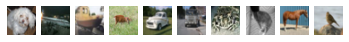

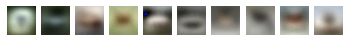

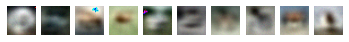

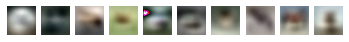

In [ ]:
fig1 = figure()
for i, file in enumerate(sorted(glob.glob('drive/My Drive/Colab Notebooks/cifar10-expts/cifar1/examples/' + '*.png'))):
    a=fig1.add_subplot(1,10,i+1)
    image = imread(file)
    imshow(image,cmap='Greys_r')
    axis('off')

fig2 = figure()
for i, file in enumerate(sorted(glob.glob('drive/My Drive/Colab Notebooks/cifar10-expts/recon_outputs/E1V0/' + '*.png'))):
    a=fig2.add_subplot(1,10,i+1)
    image = imread(file)
    imshow(image,cmap='Greys_r')
    axis('off')

fig3 = figure()
for i, file in enumerate(sorted(glob.glob('drive/My Drive/Colab Notebooks/cifar10-expts/recon_outputs/E1V1/' + '*.png'))):
    a=fig3.add_subplot(1,10,i+1)
    image = imread(file)
    imshow(image,cmap='Greys_r')
    axis('off')

fig4 = figure()
for i, file in enumerate(sorted(glob.glob('drive/My Drive/Colab Notebooks/cifar10-expts/recon_outputs/E1V2/' + '*.png'))):
    a=fig4.add_subplot(1,10,i+1)
    image = imread(file)
    imshow(image,cmap='Greys_r')
    axis('off')

**Conclusion:**

- Performance is not great using simple Linear Neural Network as I achieved in past on the MNIST dataset, this simply account to CIFAR10 being more complex dataset so we need better and more complex architecture to represent this information.
- Even different depth of network or different amount of neurons in each layer did not play any significant role in imprving the model's classification performance(stayed within 1 percent).
- Even the reconstruction using the simple Linear Neural Network is not good, and it clearly indicates that most likely we are losing some information in latent space and that is why we are not able to reccover the information.
- But we can clearly see that the reconstruction results are better for v1.1 compare to v1.0 and v1.2. I think this suggest that more depth in Autoencoder or further we are from the original image in latent space more difficult it becomes to reconstruct image. I will try to observe this more in future experiments. Note this is only for reconstruction, on classification  performance it dooes not matter much.
- The main observation is that use of Autoencoder((or node 2 as input to CNN architecture) does not necessarily improve the model's Classification performance. So the stated hypothesis does not seem to work for this particular combination of neura network and dataset. As we can see that if we set beta=0, we only train the whole architecture as a supervised task, we get the same accuracy as training both supervised and unsupervised part together(with alpha=1 and beta=1). I will explore more for other experiments. 
- The other main observation is that if we freeze the model's autoencoder(after training seprately as unsupervised training) and use these frozen weights directly(without any finetuning) as the backbone to the classifier part of the architecture we see a significant decrease in the performance.
    - This is little easier to understand as I do not expect the features that are learned for a different computer vision task(reconstruction) and use them directly(without any finetune) for a different computer vision task. Feature space would be different because they are learning for totally different objectives.
    - Still I would like to explore this more in future parts and see if it follows same behavior.

### **Experiment 2(v2). A Neural Network using both Convolutional Neural Network and Linear layers.**

Now as we saw in last section, a simple Linear Layer Neural Network did not achieve really high performance. Next, I would like to try the famous convolutional neural networks. In this experiment, I used both Convolutional Neural Networks(conv) layers as well as Linear layers. Convolutional layers helps in learning static and spatial features and so can learn some geometrical shapes which is a big help in computer vision tasks and so I expect this to work much better than experiment 1.

Please see the implementation of architectures for **experiment 2** below:

In [ ]:
class Flatten(nn.Module): # To flat the conv layer output for linear layer
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.size(0), -1)

class UnFlatten(nn.Module): # To unflat the linear layer output for conv layer
	def __init__(self, c=64, w=4, h=4):
		super(UnFlatten, self).__init__()
		self.c = c
		self.w = w
		self.h = h

	def forward(self, x):
		return x.view(x.size(0), self.c, self.w, self.h)

class autoencoderV2(nn.Module):

	def __init__(self): # Input shape is 32 for the CIFAR10 (32 = height and width)
		super(autoencoderV2, self).__init__()
		
		self.encoder  = nn.Sequential(
			nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
			nn.ReLU(inplace=True),
			nn.MaxPool2d(kernel_size=2, stride=2),
			nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
			nn.ReLU(inplace=True),
			nn.MaxPool2d(kernel_size=2, stride=2),
			nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
			nn.ReLU(inplace=True),
			nn.MaxPool2d(kernel_size=2, stride=2),
			Flatten(),
			nn.Linear(in_features=64*4*4, out_features=512),
			nn.ReLU(inplace=True)
		)
		
		self.decoder = nn.Sequential(
			nn.Linear(in_features=512, out_features=64*4*4),
			nn.ReLU(inplace=True),
			UnFlatten(64, 4, 4),
			nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2, padding=0),
			nn.ReLU(inplace=True),
			nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=2, stride=2, padding=0),
			nn.ReLU(inplace=True),
			nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=2, stride=2, padding=0)
		)

	def forward(self, x):

		x = self.encoder(x)
		x_encoded = x

		x = self.decoder(x)
		x_decoded = x

		return x_encoded, x_decoded


class classifierV2(nn.Module):

	def __init__(self, input_shape=512, num_classes=10):
		super(classifierV2, self).__init__()

		self.classifier = nn.Sequential(
			nn.Linear(in_features=input_shape, out_features=128),
			nn.ReLU(inplace=True),
			nn.Linear(in_features=128, out_features=num_classes)
		)

	def forward(self, x):
		x = self.classifier(x)
  	
		return x


class modelV2(nn.Module):
	def __init__(self, num_classes=10):
		super(modelV2, self).__init__()

		self.autoencoder = autoencoderV2()
		self.classifier = classifierV2(input_shape=512, num_classes=num_classes)

	def forward(self, x):

		x_encoded, x_decoded = self.autoencoder(x)
		x_cls = self.classifier(x_encoded)

		return x_cls, x_decoded


if __name__=='__main__':
	'''
        Please update the TRAIN_PATH, TEST_PATH or all other path locations according to your system.
    '''

	model = modelV2(num_classes=10).to(dev)
	print(model)
	
	train_dataloader = data_loader(TRAIN_PATH, batch_size=64, input_size=32, num_workers=1, pin_memory=True, train=True)
	test_dataloader = data_loader(TEST_PATH, batch_size=32, input_size=32, num_workers=1, pin_memory=True, train=False)
	
	e2e = (input("Please enter 'Y' for e2e training or 'N' for seprate and freeze encoder") or 'Y')
    recon_img = (input("Please enter 'Y' for reconstruction or 'N' for no reconstruction") or 'N')

	if e2e=='Y':
		for epoch in range(NUM_EPOCHS):
			for param in model.parameters():
				param.requires_grad=True

			optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

			train_epoch(epoch, model, train_dataloader, optimizer, 0.01, 'v2', adpt_lr=10, alpha=1.0, beta=1.0)
			test_epoch(epoch, model, test_dataloader, 'v2', alpha=1.0, beta=1.0)

	if e2e=='N':
		for epoch in range(NUM_EPOCHS):
			if epoch<(NUM_EPOCHS/2):
				for param in model.autoencoder.parameters():
					param.requires_grad=True
				for param in model.classifier.parameters():
					param.requires_grad=False

				optimizer = optim.SGD(model.autoencoder.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
	
				train_epoch(epoch, model, train_dataloader, optimizer, 0.01, 'v2', adpt_lr=5, alpha=1.0, beta=1.0)
				test_epoch(epoch, model, test_dataloader, 'v2', alpha=1.0, beta=1.0)
	
			if epoch>=(NUM_EPOCHS/2):
				for param in model.autoencoder.parameters():
					param.requires_grad=False
				for param in model.classifier.parameters():
					param.requires_grad=True

				optimizer = optim.SGD(model.classifier.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

				train_epoch(epoch-(NUM_EPOCHS/2), model, train_dataloader, optimizer, 0.001, 'v2', adpt_lr=5, alpha=1.0, beta=1.0)
				test_epoch(epoch-(NUM_EPOCHS/2), model, test_dataloader, 'v2', alpha=1.0, beta=1.0)
				

	torch.save(model.state_dict(), 'drive/My Drive/Colab Notebooks/cifar10-expts/model_E2_v1.pth')

	if recon_img=='Y':
		for file in glob.glob(EXMP_PATH + '/*.png'):
			fname = file.split('/')[-1].split('.')[0]
			img = img_processing(file, 'v2')
			pred, recon = model(img)

			construct_image(recon, fname, 'drive/My Drive/Colab Notebooks/cifar10-expts/recon_outputs/E2V0/', 'v2')


# Done!!!

### Results && Conclusion from Experiment2(v2).

**Results of Classification Accuracy:**

| Accuracy(%) | Version | Input Size | Arch Autoencoder | Arch Classifier | alpha | beta | Freeze Encoder |
| ----------- | ------- | ---------- | ---------------- | --------------- | ----- | ---- | ------------- |
| 78.23 | v2.0 | 32*32  | C(32)>C(32)>C(64)>L(512) | L(128)>L'(10) | 1.0 | 1.0 | No |
| 75.83 | v2.1 | 32*32  | C(32)>C(32)>L(512) | L(128)>L'(10) | 1.0 | 1.0 | No |
| 79.67 |  v2.2 | 32*32  | C'(32)>C(32)>C'(32)>C(64)>C(64)>L(512) | L(128)>L'(10) | 1.0 | 1.0 | No |
| 80.53 |  v2.3 | 64*64  | C'(32)>C(32)>C'(32)>C(64)>C(64)>L(512) | L(128)>L'(10) | 1.0 | 1.0 | No |
| 78.09 |  v2.0 | 32*32  | C(32)>C(32)>C(64)>L(512) | L(128)>L'(10) | 1.0 | 0.0 | No |
| 75.72 |  v2.1 | 32*32  | C(32)>C(32)>L(512) | L(128)>L'(10) | 1.0 | 0.0 | No |
| 80.48 |  v2.2 | 32*32  | C'(32)>C(32)>C'(32)>C(64)>C(64)>L(512) | L(128)>L'(10) | 1.0 | 0.0 | No |
| 80.66 |  v2.3 | 64*64  | C'(32)>C(32)>C'(32)>C(64)>C(64)>L(512) | L(128)>L'(10) | 1.0 | 0.0 | No |
| 72.01 |  v2.0 | 32*32 | C(32)>C(32)>C(64)>L(512) | L(128)>L'(10) | 1.0 | 1.0 | Yes |
| 70.08 |  v2.1 | 32*32  | C(32)>C(32)>L(512) | L(128)>L'(10) | 1.0 | 1.0 | Yes |
| 71.65 |  v2.2 | 32*32  | C'(32)>C(32)>C'(32)>C(64)>C(64)>L(512) | L(128)>L'(10) | 1.0 | 1.0 | Yes |

Representation in Table follows this structure:
- **C(Number of Output Channels)**

- **C** = (Conv + Relu + MaxPool), **C'** = (Conv + Relu), **L** = (Linear + Relu), **L'** = (Linear)  and **Accuracy(%)** is the best accuracy(from all epochs) achieved during training on testing dataset.

**Results of Autoencder Reconstruction:**

Please run the cell below to get the construction results from all the different versions of experiment 2.


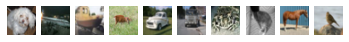

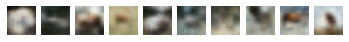

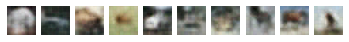

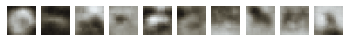

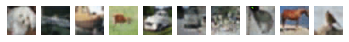

In [ ]:
fig1 = figure()
for i, file in enumerate(sorted(glob.glob('drive/My Drive/Colab Notebooks/cifar10-expts/cifar1/examples/' + '*.png'))):
    a=fig1.add_subplot(1,10,i+1)
    image = imread(file)
    imshow(image,cmap='Greys_r')
    axis('off')

fig2 = figure()
for i, file in enumerate(sorted(glob.glob('drive/My Drive/Colab Notebooks/cifar10-expts/recon_outputs/E2V0/' + '*.png'))):
    a=fig2.add_subplot(1,10,i+1)
    image = imread(file)
    imshow(image,cmap='Greys_r')
    axis('off')

fig3 = figure()
for i, file in enumerate(sorted(glob.glob('drive/My Drive/Colab Notebooks/cifar10-expts/recon_outputs/E2V1/' + '*.png'))):
    a=fig3.add_subplot(1,10,i+1)
    image = imread(file)
    imshow(image,cmap='Greys_r')
    axis('off')

fig4 = figure()
for i, file in enumerate(sorted(glob.glob('drive/My Drive/Colab Notebooks/cifar10-expts/recon_outputs/E2V2/' + '*.png'))):
    a=fig4.add_subplot(1,10,i+1)
    image = imread(file)
    imshow(image,cmap='Greys_r')
    axis('off')
fig5 = figure()
for i, file in enumerate(sorted(glob.glob('drive/My Drive/Colab Notebooks/cifar10-expts/recon_outputs/E2V3/' + '*.png'))):
    a=fig5.add_subplot(1,10,i+1)
    image = imread(file)
    imshow(image,cmap='Greys_r')
    axis('off')

As expected, the classification performance increased close to **20%** after using CNN layers in experiment 2. Even keeping the same number of layer(see v2.1) as Linear Layer based NN we can see a significantly high boost in performance. After seeing this I played around having more number of layers in Autoencoder. I saw that the even better classification performance comes when we have a deeper architecture(v2.2). In this, we use 5 CNN layers and 1 Linear layer in Autoencoder. This whole experiments also follows similar pattern in results as experiment 1. We get the best reconstruction results when we have less number of layers in the Autoencoder(v2.1) but gives the worst performance in terms of classification. And v2.2, which gives best results in classification has really bad results in Autoencoder. I also wanted to see the impact of the size of input image and we can see from v2.3 that both classification and reconstruction results has improved. Using a 64*64 input size improves the whole model. Now we can clearly see that having bigger input can help in getting superior features at the end of the encoder which improves classification performance but what I also observed is that even a deeper decoder works better when we have bigger input size. I do not know if it is True for all cases that having bigger input size will help in decoding the features(Need to try more experiments for that).

**Conclusion:**

- CNN improved the performance significantly over a very simple Linear layer neural network. We saw increse of almost **20%** which is huge.
- Rest of the results follows similar pattern to experiment 1.
- Reconstruction results are also much better using CNN layers vs only Linear layers. 
- Again, a deeper network gives superior results when it comes to classification task but givese poorer results for the reconstruction task.
    - This means having deeper or higher level features is really useful for classification task but it becomes difficult for the decoder to bring back original information.
- I also observed something interesting here: when I make input size bigger both classification and reconstruction performance increases even for the deeper acrhitecture.
    - I was expecting the classification to be better as we will be able to get feetaures in the latent space.
    - But this was not expected by me, that having larger input size is important for the decoder to bring back the original information. This is interesting how size plays a significant part in decoding the information.
- The main observation, even for this stays the same, that use of Autoencoder(or node 2 as input to CNN architecture) does not necessarily improve the model's Classification performance. So the stated hypothesis does not seem to work for this particular combination of network and dataset as well. As we can see that if we set beta=0, we only train the whole architecture as a supervised task, we get the same accuracy as training both supervised and unsupervised part together(with alpha=1 and beta=1). I will keep exploring this more for other experiments. 
- The other main observation also follows the same pattern that if we freeze the model's autoencoder(after training seprately as unsupervised training) and use these frozen weights directly(without any finetuning) as the backbone to the classifier part of the architecture we see a significant decrease in the performance.
    - Same logic: This is little easier to understand as I do not expect the features that are learned for a different computer vision task(reconstruction) and use them directly(without any finetune) for a different computer vision task. Feature space would be different because they are learning for totally different objectives.
    - Still I would keep exploring this more in future parts and see if it changes.

### **Experiment 3(v3). A Neural Network using only the Convolutional Neural Network layers.**

Now, I wanted to go even one step further where I only used the convolution layer(Except: 1 Linear layer for mapping final CNN layer's output to number of outputs). I wanted to see if removing Linear layers has any impact on Classifier's as well as on Autoencoder's performance. I am doing this because researchers lately have shown that a deep network can work same or even better when you don't use Linear layers e.g. ResNet, DenseNet, SqueezeNet vs VGG16, AlexNet(these uses Linear layers).

Please see the implementation of architectures for **experiment 3** below:

In [ ]:
#@title Default title text
class Flatten(nn.Module): # To flat the conv layer output for linear layer
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.size(0), -1)


class autoencoderV3(nn.Module):
    def __init__(self): # Input shape is 32 for the CIFAR10 (32 = height and width)
        super(autoencoderV3, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2,stride=2, padding=0),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2,stride=2, padding=0),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=2,stride=2, padding=0),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=2,stride=2, padding=0),
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x_encoded = x
        
        x = self.decoder(x)
        x_decoded = x
        
        return x_encoded, x_decoded


class classifierV3(nn.Module):
	
    def __init__(self, in_channels=64, num_classes=10):
        super(classifierV3, self).__init__()
        
        self.classifier = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            Flatten(),
            nn.Linear(in_features=64*2*2, out_features=num_classes)
        )
    
    def forward(self, x):
        x = self.classifier(x)
        
        return x


class modelV3(nn.Module):
    
    def __init__(self, num_classes=10):
        super(modelV3, self).__init__()
		
        self.autoencoder = autoencoderV3()
        self.classifier = classifierV3(in_channels=64, num_classes=num_classes)
        
    def forward(self, x):
        
        x_encoded, x_decoded = self.autoencoder(x)
        x_cls = self.classifier(x_encoded)
        
        return x_cls, x_decoded



if __name__=='__main__':
    '''
        Please update the TRAIN_PATH, TEST_PATH or al other path locations according to your system.
    '''
	model = modelV3(num_classes=10).to(dev)
	print(model)
	
	train_dataloader = data_loader(TRAIN_PATH, batch_size=64, input_size=32, num_workers=1, pin_memory=True, train=True)
	test_dataloader = data_loader(TEST_PATH, batch_size=32, input_size=32, num_workers=1, pin_memory=True, train=False)
	
    e2e = (input("Enter 'Y' for e2e training or 'N' for seprate and freeze encoder") or 'Y')
    recon_img = (input("Enter 'Y' for reconstruction or 'N' for no reconstruction") or 'N')

    if e2e=='Y':
        for epoch in range(NUM_EPOCHS):
            for param in model.parameters():
                param.requires_grad=True

            optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

            train_epoch(epoch, model, train_dataloader, optimizer, 0.01, 'v3', adpt_lr=10, alpha=1.0, beta=0.0)
            test_epoch(epoch, model, test_dataloader, 'v3', alpha=1.0, beta=0.0)

    if e2e=='N':
        for epoch in range(NUM_EPOCHS):
            if epoch<(NUM_EPOCHS/2):
                for param in model.autoencoder.parameters():
                    param.requires_grad=True
                for param in model.classifier.parameters():
                    param.requires_grad=False

                optimizer = optim.SGD(model.autoencoder.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
    
                train_epoch(epoch, model, train_dataloader, optimizer, 0.01, 'v3', adpt_lr=5, alpha=1.0, beta=1.0)
                test_epoch(epoch, model, test_dataloader, 'v3', alpha=1.0, beta=1.0)
    
            if epoch>=(NUM_EPOCHS/2):
                for param in model.autoencoder.parameters():
                    param.requires_grad=False
                for param in model.classifier.parameters():
                    param.requires_grad=True

                optimizer = optim.SGD(model.classifier.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

                train_epoch(epoch-(NUM_EPOCHS/2), model, train_dataloader, optimizer, 0.001, 'v2', adpt_lr=5, alpha=1.0, beta=1.0)
                test_epoch(epoch-(NUM_EPOCHS/2), model, test_dataloader, 'v2', alpha=1.0, beta=1.0)
			

	torch.save(model.state_dict(), 'drive/My Drive/Colab Notebooks/cifar10-expts/model_E3_v1.pth')

    if recon_img=='Y':
        for file in glob.glob(EXMP_PATH + '/*.png'):
        	fname = file.split('/')[-1].split('.')[0]
            img = img_processing(file, 'v3')
            pred, recon = model(img)

        	construct_image(recon, fname, 'drive/My Drive/Colab Notebooks/cifar10-expts/recon_outputs/E3V0/', 'v3')

# Done!!!

### Results && Conclusion from Experiment3(v3).

**Results of Classification Accuracy:**

| Accuracy(%) | Version | Input Size | Arch Autoencoder | Arch Classifier | alpha | beta | Freeze Encoder |
| ----------- | ------- | ---------- | ---------------- | --------------- | ----- | ---- | ------------- |
| 77.42 | v3.0 | 32*32  | C(32)>C(32)>C(64)>C(64) | C'(64)>L'(10) | 1.0 | 1.0 | No |
| 76.53 | v3.1 | 32*32  | C(32)>C(32)>C(64) | C(64)>C'(64)>L'(10) | 1.0 | 1.0 | No |
| 78.07 |  v3.2 | 32*32  | C'(32)>C(32)>C'(32)>C(32)>C'(64)>C(64) | C(64)>L'(10) | 1.0 | 1.0 | No |
| 79.14 |  v3.3 | 32*32  | C'(32)>C(32) | C'(32)>C(32)>C'(64)>C(64)>C(64)>L'(10) | 1.0 | 1.0 | No |
| 77.63 | v3.0 | 32*32  | C(32)>C(32)>C(64)>C(64) | C'(64)>L'(10) | 1.0 | 0.0 | No |
| 77.80 | v3.1 | 32*32  | C(32)>C(32)>C(64) | C(64)>C'(64)>L'(10) | 1.0 | 0.0 | No |
| 80.65 |  v3.2 | 32*32  | C'(32)>C(32)>C'(32)>C(32)>C'(64)>C(64) | C(64)>L'(10) | 1.0 | 0.0 | No |
| 79.52 |  v3.3 | 32*32  | C'(32)>C(32) | C'(32)>C(32)>C'(64)>C(64)>C(64)>L'(10) | 1.0 | 0.0 | No |
| 62.76 | v3.0 | 32*32  | C(32)>C(32)>C(64)>C(64) | C'(64)>L'(10) | 1.0 | 1.0 | Yes |
| 54.55 | v3.1 | 32*32  | C(32)>C(32)>C(64) | C(64)>C'(64)>L'(10) | 1.0 | 1.0 | Yes |
| 64.67 |  v3.2 | 32*32  | C'(32)>C(32)>C'(32)>C(32)>C'(64)>C(64) | C(64)>L'(10) | 1.0 | 1.0 | Yes |
| 70.79 |  v3.3 | 32*32  | C'(32)>C(32) | C'(32)>C(32)>C'(64)>C(64)>C(64)>L'(10) | 1.0 | 1.0 | Yes |

Representation in Table follows this structure:
- **C(Number of Output Channels)**

- **C** = (Conv + Relu + MaxPool), **C'** = (Conv + Relu), **L** = (Linear + Relu), **L'** = (Linear)  and **Accuracy(%)** is the best accuracy(from all epochs) achieved during training on testing dataset.

**Results of Autoencder Reconstruction:**

Please run the cell below to get the construction results from all the different versions of experiment 3.

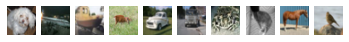

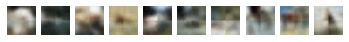

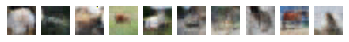

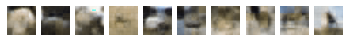

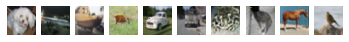

In [ ]:
fig1 = figure()
for i, file in enumerate(sorted(glob.glob('drive/My Drive/Colab Notebooks/cifar10-expts/cifar1/examples/' + '*.png'))):
    a=fig1.add_subplot(1,10,i+1)
    image = imread(file)
    imshow(image,cmap='Greys_r')
    axis('off')

fig2 = figure()
for i, file in enumerate(sorted(glob.glob('drive/My Drive/Colab Notebooks/cifar10-expts/recon_outputs/E3V0/' + '*.png'))):
    a=fig2.add_subplot(1,10,i+1)
    image = imread(file)
    imshow(image,cmap='Greys_r')
    axis('off')

fig3 = figure()
for i, file in enumerate(sorted(glob.glob('drive/My Drive/Colab Notebooks/cifar10-expts/recon_outputs/E3V1/' + '*.png'))):
    a=fig3.add_subplot(1,10,i+1)
    image = imread(file)
    imshow(image,cmap='Greys_r')
    axis('off')

fig4 = figure()
for i, file in enumerate(sorted(glob.glob('drive/My Drive/Colab Notebooks/cifar10-expts/recon_outputs/E3V2/' + '*.png'))):
    a=fig4.add_subplot(1,10,i+1)
    image = imread(file)
    imshow(image,cmap='Greys_r')
    axis('off')
fig5 = figure()
for i, file in enumerate(sorted(glob.glob('drive/My Drive/Colab Notebooks/cifar10-expts/recon_outputs/E3V3/' + '*.png'))):
    a=fig5.add_subplot(1,10,i+1)
    image = imread(file)
    imshow(image,cmap='Greys_r')
    axis('off')

In this experiment, I did not see any significant improvment in the Classifier's performance compare to the experiment 2. So having only the Convolutional layer in the architecture did not increase the classification performance for this particular dataset and network combination. **I observed something really interesting: that having only convolutional layers in the Autoencoder architecture achieves much better reconstruction results.** The results still follow similar pattern when it comes to number of layers i.e. deeper network gives better classification results but poor reconstrution results and shallow  network  achieve better reconstruction results. In fact when I use smaller autoencoder(v3.3) it is really hard to distinguish between the real images vs reconstrcuted images from v3.3 so reconstruction is almost close to perfect.

Here, I played around number of layers for both autoencoder and classifier parts of the complete architecture. So using low number of layer in Autoencoder and then more layers in Classifier achieves the best results for both tasks of classification and reconstruction. **Well, this is really interesting because this is what we also obsereved in above experiments that shallower autoencoder achieves good results for reconstruction and to achieve better results for classification task we can get higher dimensional features by using the more layers in the classifier architecture**. This is definitely a new finding for me when it comes to designing an architeture which utilizes both Autoencoders and Classifiers and I will also try to this information it for getting a similar or even better model in the coming experiement. This will be my final architecture for different types experiments. **Please note that I am not saything this is the most optimal architecture, but I believe this would work great for next set of experiments.**

**Conclusion**

- Only using CNN I did not see any significant performance in the final classification performance on this dataset.
- In this also, the results follows similar pattern to above done experiments.. 
- Again, a deeper network gives superior results when it comes to classification task but gives poorer results for the reconstruction task.
    - But in this, I was able to make a network deeper by using more layers in the classifier part and a shallow network for the autoencoder part.
    - By doing this I am able to achieve really high performance for both classification and the reconstruction task. 
- The main observation, even for this stays the same, that use of Autoencoder(or node 2 as input to CNN architecture) does not necessarily improve the model's Classification performance. So the stated hypothesis does not seem to work for this particular combination of network and dataset as well. As we can see that if we set beta=0, we only train the whole architecture as a supervised task, we get the same accuracy as training both supervised and unsupervised part together(with alpha=1 and beta=1). 
- The other main observation also follows the same pattern as before that if we freeze the model's autoencoder(after training seprately as unsupervised training) and use these frozen weights directly(without any finetuning) as the backbone to the classifier part of the architecture we see a significant decrease in the performance.
    - Same logic: This is little easier to understand as I do not expect the features that are learned for a different computer vision task(reconstruction) and use them directly(without any finetune) for a different computer vision task. Feature space would be different because they are learning for totally different objectives.



### **Experiment 4(v4). A Neural Network designed from the observations made in above three experiments.**

After doing the above three experiments, I have better understanding of autoencoder and their use for supervised tasks. From experiment number 2 and 3 we can see having a shallower autoencoder is good for reconstruction and having deeper classifier is good for classification performance. We also notice that having linear layers towards the end in the model can help slightly for getting better performance than compared to just using convolution layers. So based on all these observations, I made a very simple new architecture named modelV4. This one has 2 conv layers in the autoencoder just as v3.2 and more layers(3 conv + 3 linear) in classifier because we want a deeper architecture for better classification performance. 

**For all next experiments I will use this architecture and perform different experiemnts to hande other aspects.**

We started with this architecture and trained and end-to-end model and achieved results as shown below.

Please see the implementation of the architecture for **experiment 4** below:

In [ ]:
class Flatten(nn.Module): # To flat the conv layer output for linear layer
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.size(0), -1)

class autoencoderV4(nn.Module):
	
	def __init__(self):
		super(autoencoderV4, self).__init__()

		self.encoder = nn.Sequential(
			nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
			nn.ReLU(inplace=True),
			nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
			nn.ReLU(inplace=True),
			nn.MaxPool2d(kernel_size=2, stride=2),
		)

		self.decoder = nn.Sequential(
			nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=2, stride=2, padding=0),
			nn.ReLU(inplace=True),
			nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=1, stride=1, padding=0)
		)

	def forward(self, x):

		x = self.encoder(x)
		x_encoded = x

		x = self.decoder(x)
		x_decoded = x

		return x_encoded, x_decoded


class classifierV4(nn.Module):
	
	def __init__(self, in_channels=32, num_classes=10):
		super(classifierV4, self).__init__()

		self.classifier = nn.Sequential(
			nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=3, stride=1, padding=1),
			nn.ReLU(inplace=True),
			nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
			nn.ReLU(inplace=True),
			nn.MaxPool2d(kernel_size=2, stride=2),
			nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
			nn.ReLU(inplace=True),
			nn.MaxPool2d(kernel_size=2, stride=2),
			Flatten(),
			nn.Linear(in_features=64*4*4, out_features=512),
			nn.ReLU(inplace=True),
			nn.Linear(in_features=512, out_features=128),
			nn.ReLU(inplace=True),
			nn.Linear(in_features=128, out_features=num_classes)
		)

	def forward(self, x):
		x = self.classifier(x)
  		
		return x


class modelV4(nn.Module):
	
	def __init__(self, num_classes=10):
		super(modelV4, self).__init__()
		
		self.autoencoder = autoencoderV4()
		self.classifier = classifierV4(in_channels=32, num_classes=num_classes)

	def forward(self, x):

		x_encoded, x_decoded = self.autoencoder(x)
		x_cls = self.classifier(x_encoded)
		
		return x_cls, x_decoded


if __name__=='__main__':
	'''
        Please update the TRAIN_PATH, TEST_PATH or al other path locations according to your system.
    '''
	model = modelV4(num_classes=10).to(dev)
	print(model)
	
	train_dataloader = data_loader(TRAIN_PATH, batch_size=64, input_size=32, num_workers=1, pin_memory=True, train=True)
	test_dataloader = data_loader(TEST_PATH, batch_size=32, input_size=32, num_workers=1, pin_memory=True, train=False)
	
	e2e = (input("Enter 'Y' for e2e training or 'N' for seprate and freeze encoder") or 'Y')
    recon_img = (input("Enter 'Y' for reconstruction or 'N' for no reconstruction") or 'N')

	if e2e=='Y':
		for epoch in range(NUM_EPOCHS):
			for param in model.parameters():
				param.requires_grad=True

			optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

			train_epoch(epoch, model, train_dataloader, optimizer, 0.01, 'v4', adpt_lr=10, alpha=1.0, beta=1.0)
			test_epoch(epoch, model, test_dataloader, 'v4', alpha=1.0, beta=1.0)

	if e2e=='N':
		for epoch in range(NUM_EPOCHS):
			if epoch<(NUM_EPOCHS/2):
				for param in model.autoencoder.parameters():
					param.requires_grad=True
				for param in model.classifier.parameters():
					param.requires_grad=False

				optimizer = optim.SGD(model.autoencoder.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
	
				train_epoch(epoch, model, train_dataloader, optimizer, 0.01, 'v3', adpt_lr=5, alpha=1.0, beta=1.0)
				test_epoch(epoch, model, test_dataloader, 'v3', alpha=1.0, beta=1.0)
	
			if epoch>=(NUM_EPOCHS/2):
				for param in model.autoencoder.parameters():
					param.requires_grad=False
				for param in model.classifier.parameters():
					param.requires_grad=True

				optimizer = optim.SGD(model.classifier.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

				train_epoch(epoch-(NUM_EPOCHS/2), model, train_dataloader, optimizer, 0.001, 'v2', adpt_lr=5, alpha=1.0, beta=1.0)
				test_epoch(epoch-(NUM_EPOCHS/2), model, test_dataloader, 'v2', alpha=1.0, beta=1.0)
				

	torch.save(model.state_dict(), 'drive/My Drive/Colab Notebooks/cifar10-expts/model_E4_v1.pth')

	if recon_img=='Y':
		for file in glob.glob(EXMP_PATH + '/*.png'):
			fname = file.split('/')[-1].split('.')[0]
		    img = img_processing(file, 'v4')
		    pred, recon = model(img)

			construct_image(recon, fname, 'drive/My Drive/Colab Notebooks/cifar10-expts/recon_outputs/E4V0/', 'v4')

# Done!!!




### Results && Conclusion from Experiment4(v4).

**Results of Classification Accuracy:**

| Accuracy(%) | Version | Input Size | Arch Autoencoder | Arch Classifier | alpha | beta | Freeze Encoder | Regularizer |
| ----------- | ------- | ---------- | ---------------- | --------------- | ----- | ---- | -------------- | ----------- |
| 80.15 | v4.0 | 32*32  | C'(32)>C(32) | C'(64)>C(64)>C(64)>L(512)>L(128)>L'(10) | 1.0 | 1.0 | No | No |
| 80.58 | v4.0 | 32*32  | C'(32)>C(32) | C'(64)>C(64)>C(64)>L(512)>L(128)>L'(10) | 1.0 | 0.0 | No | No |
| 72.52 | v4.0 | 32*32  | C'(32)>C(32) | C'(64)>C(64)>C(64)>L(512)>L(128)>L'(10) | 1.0 | 1.0 | Yes | No |

Representation in Table follows this structure:
- **C(Number of Output Channels)**

- **C** = (Conv + Relu + MaxPool), **C'** = (Conv + Relu), **L** = (Linear + Relu), **L'** = (Linear)  and **Accuracy(%)** is the best accuracy(from all epochs) achieved during training on testing dataset.

**Results of Autoencder Reconstruction:**

Please run the cell below to get the construction results from all the different versions of experiment 4.

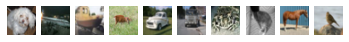

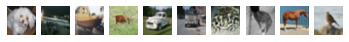

In [ ]:
fig1 = figure()
for i, file in enumerate(sorted(glob.glob('drive/My Drive/Colab Notebooks/cifar10-expts/cifar1/examples/' + '*.png'))):
    a=fig1.add_subplot(1,10,i+1)
    image = imread(file)
    imshow(image,cmap='Greys_r')
    axis('off')

fig2 = figure()
for i, file in enumerate(sorted(glob.glob('drive/My Drive/Colab Notebooks/cifar10-expts/recon_outputs/E4V0/' + '*.png'))):
    a=fig2.add_subplot(1,10,i+1)
    image = imread(file)
    imshow(image,cmap='Greys_r')
    axis('off')

Even though this architecture achieved the highest accuracy performance so far. 

**Conclusion**

- This model achieves the highest performance so far(even tho performance is not much better) for each version.
- The main observation, even for this stays the same, that use of Autoencoder(or node 2 as input to CNN architecture) does not necessarily improve the model's Classification performance. So the stated hypothesis does not seem to work for this particular combination of network and dataset as well. As we can see that if we set beta=0, we only train the whole architecture as a supervised task, we get the same accuracy as training both supervised and unsupervised part together(with alpha=1 and beta=1). 
- The other main observation also follows the same pattern as before that if we freeze the model's autoencoder(after training seprately as unsupervised training) and use these frozen weights directly(without any finetuning) as the backbone to the classifier part of the architecture we see a significant decrease in the performance.
- Note: I am not saying this is the best possible model, but I definately think that my past experiments helped me achieving a better architeture for both reconstruction task and classification task.
- **This would work as a perfect model for my future experiments of how to handle the data imbalance.**

***After doing all four experiments, I would like to comment on the hypothesis of using Autoencoder's encoder part as backbone to the classifier can improve the classification performance. I personally think that CIFAR10 might be really simple dataset where even a simple supervised learning can help in achieving good results. So I do not think hypothesis is incorrect but I believe on simpler dataset, such as CIFAR10, we might get salient features just from the supervised based architecture and do not need to use the autoencoder to get best features for the supervised task. Also, Autoencoder can be really useful where we have plently of unlabel images and a very less amount of the label dataset. I would like to perform and experiement to varify this hypothesis that CIFAR-10 is very simple dataset and if we make it more complex we might see an impact of the autoencoder part as the input for the classifier part.***
- **CIFAR10 is very simple dataset and a large amount of labeled data is available, so I do not see any specific impact of the stated hypothesis for this dataset.**





## **Data Imabalance: Different solutions and experiments.**

Data Imbalance is one of the major issue for any industry comparing it to the reseacrh world, where many public datasets are available for research work. Esp. I can see how for a construction based company where we are trying to inspect anomlies at some remote locations and so these things rarely happens and so will always lead to data imbalance. I would use my knowledge gain over the years to tackle the problem of the data imbalance and finally I would like to give some remarks how even more complex algorihms can help in solving this problem of data imbaance. For all this experiments/solutions I would use the architecture from the experiment 4 here. *Please note that I am just using it as a sample architecture, any technique that I discuss below can be used for any type of Deep Neural Network(both self designed or some standard architectures such as VGG or ResNet etc.).*

So let's have a look at the different algorithms/approaches for handling the data imabalance problem.

First let's bring our modelV4 for this set of experiments:


In [ ]:
class Flatten(nn.Module): # To flat the conv layer output for linear layer
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.size(0), -1)

class autoencoderV4(nn.Module):
	
	def __init__(self):
		super(autoencoderV4, self).__init__()

		self.encoder = nn.Sequential(
			nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
			nn.ReLU(inplace=True),
			nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
			nn.ReLU(inplace=True),
			nn.MaxPool2d(kernel_size=2, stride=2),
		)

		self.decoder = nn.Sequential(
			nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=2, stride=2, padding=0),
			nn.ReLU(inplace=True),
			nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=1, stride=1, padding=0)
		)

	def forward(self, x):

		x = self.encoder(x)
		x_encoded = x

		x = self.decoder(x)
		x_decoded = x

		return x_encoded, x_decoded


class classifierV4(nn.Module):
	
	def __init__(self, in_channels=32, num_classes=10):
		super(classifierV4, self).__init__()

		self.classifier = nn.Sequential(
			nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=3, stride=1, padding=1),
			nn.ReLU(inplace=True),
			nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
			nn.ReLU(inplace=True),
			nn.MaxPool2d(kernel_size=2, stride=2),
			nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
			nn.ReLU(inplace=True),
			nn.MaxPool2d(kernel_size=2, stride=2),
			Flatten(),
			nn.Linear(in_features=64*4*4, out_features=512),
			nn.ReLU(inplace=True),
			nn.Linear(in_features=512, out_features=128),
			nn.ReLU(inplace=True),
			nn.Linear(in_features=128, out_features=num_classes)
		)

	def forward(self, x):
		x = self.classifier(x)
  		
		return x


class modelV4(nn.Module):
	
	def __init__(self, num_classes=10):
		super(modelV4, self).__init__()
		
		self.autoencoder = autoencoderV4()
		self.classifier = classifierV4(in_channels=32, num_classes=num_classes)

	def forward(self, x):

		x_encoded, x_decoded = self.autoencoder(x)
		x_cls = self.classifier(x_encoded)
		
		return x_cls, x_decoded

# Done!!!

NameError: ignored

### 1. Using Undersampling.

Undersampling, it is one of the easiest approach to try for the data imblanace. In this, we bring all classes's images to almost equal number. We can randomly choose(from classes with more data) number of images almost equal to class which has low amount of data. E.g. for this case we can choose 50% dataset for roughly all classes(other than the 3). This is reasonable to do when we feel we have enough number of images for all classes including the classes with lower number of images or to put in simple words when we have abundance of data :). I am not sure how well this will work for this case, but it is worth to give it a try.

In [ ]:
if __name__=='__main__':
	'''
        Please update the TRAIN_PATH, TEST_PATH or al other path locations according to your system.
    '''
	model = modelV4(num_classes=10).to(dev)
	print(model)
 
    # Comment the next 2 lines to run on Original dataset(with only 3 class 50% data)
    TRAIN_PATH = 'drive/My Drive/Colab Notebooks/cifar10-expts/cifar_us/train'
    TEST_PATH = 'drive/My Drive/Colab Notebooks/cifar10-expts/cifar_us/test'

	train_dataloader = data_loader(TRAIN_PATH, batch_size=64, input_size=32, num_workers=1, pin_memory=True, train=True)
	test_dataloader = data_loader(TEST_PATH, batch_size=32, input_size=32, num_workers=1, pin_memory=True, train=False)
	
	for epoch in range(NUM_EPOCHS):
		for param in model.parameters():
			param.requires_grad=True

		optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

		train_epoch(epoch, model, train_dataloader, optimizer, 0.01, 'v4', adpt_lr=10, alpha=1.0, beta=1.0)
		test_epoch(epoch, model, test_dataloader, 'v4', alpha=1.0, beta=1.0)
  
  # Done!!!

### Results && Conclusion from Undersampling.

**Results of Classification Accuracy**

| Accuracy(%) | Version | Input Size | Arch Autoencoder | Arch Classifier | alpha | beta | Freeze Encoder | Data |
| ----------- | ------- | ---------- | ---------------- | --------------- | ----- | ---- | -------------- | ---- |
| 80.15 | v4.0 | 32*32  | C'(32)>C(32) | C'(64)>C(64)>C(64)>L(512)>L(128)>L'(10) | 1.0 | 1.0 | No | Original |
| 77.07 | v4.0 | 32*32  | C'(32)>C(32) | C'(64)>C(64)>C(64)>L(512)>L(128)>L'(10) | 1.0 | 1.0 | No | Undersampled |


Undersampling did not help in improving the performance of the model, infact it led to a poorer performance. So for CIFAR10 dataset and the network I chose it is important to have more information/more images.

**Conclusion**
- Undersampling results are poorer than the results we achieved from training on given/original constrained dataset.
- So having less images leads to poor performance atleast for this Dataset and Network combination.
- Accuracy decreased by ~**3%** from the original accuracy.



### 2. Using Oversampling.

Oversampling, it is also one of the easiest approach to try for the data imblanace. This just exactky the reverse of Undersample. In this we can try to have more data for the classes which has less number of data. Simplest way to do it the repetition of data. But we can also use some sophisticated approaches such as **SMOTE(Synthetic Minority Over Sampling Technique)**. For this experiment, I just copy 2500 images one more time for the classes with less images. This is reasonable to do when we feel we have enough varities in the given data itself and copying them would be a nice way of having more images of different varities and hence better feature learning. I am not sure how well this will work for this case, but it is worth to give it a try.

In [ ]:
if __name__=='__main__':
	'''
        Please update the TRAIN_PATH, TEST_PATH or al other path locations according to your system.
    '''
	model = modelV4(num_classes=10).to(dev)
	print(model)
 
    # Comment the next 2 lines to run on Original dataset(with only 3 class 50% data)
    TRAIN_PATH = 'drive/My Drive/Colab Notebooks/cifar10-expts/cifar_os/train'
    TEST_PATH = 'drive/My Drive/Colab Notebooks/cifar10-expts/cifar_os/test'

	train_dataloader = data_loader(TRAIN_PATH, batch_size=64, input_size=32, num_workers=1, pin_memory=True, train=True)
	test_dataloader = data_loader(TEST_PATH, batch_size=32, input_size=32, num_workers=1, pin_memory=True, train=False)
	
	for epoch in range(NUM_EPOCHS):
		for param in model.parameters():
			param.requires_grad=True

		optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

		train_epoch(epoch, model, train_dataloader, optimizer, 0.01, 'v4', adpt_lr=10, alpha=1.0, beta=1.0)
		test_epoch(epoch, model, test_dataloader, 'v4', alpha=1.0, beta=1.0)
  
  # Done!!!

### Results && Conclusion from Oversampling.

**Results of Classification Accuracy**

| Accuracy(%) | Version | Input Size | Arch Autoencoder | Arch Classifier | alpha | beta | Freeze Encoder | Data |
| ----------- | ------- | ---------- | ---------------- | --------------- | ----- | ---- | -------------- | ---- |
| 80.15 | v4.0 | 32*32  | C'(32)>C(32) | C'(64)>C(64)>C(64)>L(512)>L(128)>L'(10) | 1.0 | 1.0 | No | Original |
| 79.89 | v4.0 | 32*32  | C'(32)>C(32) | C'(64)>C(64)>C(64)>L(512)>L(128)>L'(10) | 1.0 | 1.0 | No | Oversampled |


Oversampling achieved similar results to the original performance of the model, and it performed way better than the undersampling technique. So for CIFAR10 dataset and the network I chose it is important to have more information/more images, as we can clearly see it from the comparision of undersample vs oversample.

**Conclusion**
- Oversample results are quite close to the results we got just training on the directly the given dataset.
- So having more images helps in improving performance at least for this Dataset and Network combination.
- We saw more than 2% increase in the performance of model(V4) using oversampled data compare to undersampled dataset.(This is still lower than the original given data)



### 3. Using Weights regularization, Dropout Layers && WeightedRandomSampler.

Sometimes, having less data for any specific class can lead to the overfit for the classes with more number of datasets and hence overall poor performance of the final network during the test phase. Especially, when you see the training log of the modelV4 when trained on the imbalance dataset we see how the train_loss value is always decreasing but test_loss value after decreasing for a while it starts to increase again. This is a very simple sign of overfitting of the model on the given imbalanced dataset. To remedy this we can use few very simple techniques such as:
- Use the weight L2 regularizer in the loss functioin: **A loss function based approach**
    - In this, we add the magnitude of weights in the loss function and which keeps a constraint on them and does not let them to be really high values: which can be a simply overfitted model if we allow large values.
- Or add some Dropout layers in the original architecture: **A architecture modification based approach**
    - A really cool idea discussed in 2014 too handle overfit, this basically randomly drops neurons which forces network to learn many different architectures and forces weights to adjust accordingly and not let overfit.
- Or use the **WeightedRandomSampler** method from the PyTorch libraray which is designed for handling the data imabalance and avoid the problem of overfitting as well: **A Data Augumentation or Management based appraoch**
    - This pass the images in a batch equallly distributed from all classes and not just clsses with more images so help in both overfitting and imbalance
    - I am not sure how well this will work for this case, because the data is not that skewered and number is really high for each classs(even the one with less data=2500) but this will be superhelpful in cases where data is highly skewered and very low number of images.

Let's try these ideas and hope we can see improvement.

Please see the implementation of all these approaches below:

In [ ]:
# 1. Regularizer in train_epoch function.
# We only add gamma as an additional args for the L2_reg loss, rest is same as train_epoch method above

def train_epoch_wreg(epoch, model, dataloader, optimizer, base_lr, version, adpt_lr=10, alpha=1.0, beta=1.0, gamma=0.001):
    model.train()

    lr =  base_lr * (0.1 ** (epoch // adpt_lr)) # Adaptive Learning Rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    total_loss = 0.0
    total_cls_loss = 0.0
    total_auto_loss = 0.0
    total_reg_loss = 0.0
    
    for batch_idx, (data, label) in enumerate(dataloader):

        data = data.to(dev)
        label = label.to(dev)
        if version == 'v1':
            data = data.view(data.shape[0], -1)
            
        optimizer.zero_grad() # Resetting the grads back to zero.
        
        pred, recon = model(data) # Getting predictions from the model

        l2_reg=None
        for param in model.parameters():
            if l2_reg is None:
                l2_reg=0.5*torch.sum(param**2)
            else:
                l2_reg=l2_reg+0.5*torch.sum(param**2) 
        
        cls_loss = classifier_loss(pred, label)
        auto_loss = autoencoder_loss(recon, data)
        reg_loss = l2_reg
        loss = alpha*cls_loss + beta*auto_loss + gamma*reg_loss # Weighted sum for total loss
        
        loss.backward() # Do backprop
        optimizer.step() # Update parameters
        
        total_loss += loss.item()
        total_cls_loss += alpha*cls_loss.item()
        total_auto_loss += beta*auto_loss.item()
        total_reg_loss +=gamma*reg_loss.item()
        
        if batch_idx%200 == 0:
            print("batch idx: {}, total loss: {:.6f}, cls loss: {:.6f}, auto loss: {:.6f}, reg loss: {:.6f}".format(batch_idx+1, loss, cls_loss, auto_loss, reg_loss))
    
    total_loss = total_loss/len(dataloader)
    total_cls_loss = total_cls_loss/len(dataloader)
    total_auto_loss = total_auto_loss/len(dataloader)
    total_reg_loss = total_reg_loss/len(dataloader)
    
    print("Training--> epoch number: {}, lr: {:.6f}, total loss: {:.6f}, cls loss: {:.6f}, auto loss: {:.6f}, reg loss: {:.6f}".format(epoch+1, lr, total_loss, total_cls_loss, total_auto_loss, total_reg_loss))
    return


# 2. Adding droput in Classifier section of the arrchitecture.

class classifierV4_wdropout(nn.Module): # I renamed it, now we can use this as well as odler depending on the situation
	
	def __init__(self, in_channels=32, num_classes=10):
		super(classifierV4_wdropout, self).__init__()

		self.classifier = nn.Sequential(
			nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=3, stride=1, padding=1),
			nn.ReLU(inplace=True),
			nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
			nn.ReLU(inplace=True),
			nn.MaxPool2d(kernel_size=2, stride=2),
			nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
			nn.ReLU(inplace=True),
			nn.MaxPool2d(kernel_size=2, stride=2),
			Flatten(),
			nn.Linear(in_features=64*4*4, out_features=512),
			nn.ReLU(inplace=True),
            nn.Dropout(),
			nn.Linear(in_features=512, out_features=128),
			nn.ReLU(inplace=True),
            nn.Dropout(),
			nn.Linear(in_features=128, out_features=num_classes)
		)

	def forward(self, x):
		x = self.classifier(x)
  		
		return x


class modelV4_wdropout(nn.Module): #I renamed it too.
	
	def __init__(self, num_classes=10):
		super(modelV4_wdropout, self).__init__()
		
		self.autoencoder = autoencoderV4()
		self.classifier = classifierV4_wdropout(in_channels=32, num_classes=num_classes)

	def forward(self, x):

		x_encoded, x_decoded = self.autoencoder(x)
		x_cls = self.classifier(x_encoded)
		
		return x_cls, x_decoded

# 3. WeightedRandomSamples 

class_count = np.array([5000, 5000, 2500, 5000, 2500, 5000, 5000, 5000, 5000, 2500])
total_nums = (50000-7500)
weights = np.zeros(total_nums)
k=0
for i in range(len(class_count)):
    for j in range(class_count[i]):
        weights[k] = 1./class_count[i]
        k+=1
        
samples_weight = torch.from_numpy(weights)
samples_weigth = samples_weight.double()
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

def data_loader_wsampler(path, batch_size=64, input_size=32, num_workers=1, pin_memory=True, train=True):

    if train: # If training
        if input_size==224:
            augumentation = transforms.Compose([
                transforms.Scale(256),
                transforms.RandomCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=MEAN, std=STD),
            ])
        if input_size==32:
            augumentation = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=MEAN, std=STD),
            ])
        return data.DataLoader(
            datasets.ImageFolder(path,
                augumentation),
                batch_size=batch_size,
                num_workers=num_workers,
                pin_memory=pin_memory,
                sampler=sampler
            )
            
    else: # If testing
        if input_size==224:
            augumentation = transforms.Compose([
                transforms.Scale(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=MEAN, std=STD),
            ])
        if input_size==32:
            augumentation = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=MEAN, std=STD),
            ])
        
        return data.DataLoader(
            datasets.ImageFolder(path,
                augumentation),
                batch_size=batch_size,
                shuffle=False,
                num_workers=num_workers,
                pin_memory=pin_memory
            )


if __name__=='__main__':
    
    use_drop = (input("Please enter 'Y' if you want to use Dropout") or 'N')
    use_wsampler = (input("Please enter 'Y' if you want to use WeightedRandomSample") or 'N')
    use_reg = (input("Please enter 'Y' if you want to use Weight Regularization") or 'Y')

    if use_drop=='Y':
        model = modelV4_wdropout(num_classes=10).to(dev)
    else:
        model = modelV4(num_classes=10).to(dev)
    print(model)

    if use_wsampler=='Y':
        train_dataloader = data_loader_wsampler(TRAIN_PATH, batch_size=64, input_size=32, num_workers=1, pin_memory=True, train=True)
    else:
        train_dataloader = data_loader(TRAIN_PATH, batch_size=64, input_size=32, num_workers=1, pin_memory=True, train=True)
    test_dataloader = data_loader(TEST_PATH, batch_size=32, input_size=32, num_workers=1, pin_memory=True, train=False)
	
	for epoch in range(NUM_EPOCHS):
		for param in model.parameters():
			param.requires_grad=True

		optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

        if use_reg=='Y':
		    train_epoch_wreg(epoch, model, train_dataloader, optimizer, 0.01, 'v4', adpt_lr=10, alpha=1.0, beta=1.0, gamma=0.001)
		else:
            train_epoch(epoch, model, train_dataloader, optimizer, 0.01, 'v4', adpt_lr=10, alpha=1.0, beta=1.0)
        test_epoch(epoch, model, test_dataloader, 'v4', alpha=1.0, beta=1.0)
  

  # Done!!!

### Results && Conclusion from Weight Regularization, Dropout and WeightSampler.

**Results of Classification Accuracy**

| Accuracy(%) | Version | Input Size | Arch Autoencoder | Arch Classifier | alpha | beta | Regularizarion | Dropout | WeightedSampling |
| ----------- | ------- | ---------- | ---------------- | --------------- | ----- | ---- | -------------- | ------- | ------------- |
| 80.15 | v4.0 | 32*32  | C'(32)>C(32) | C'(64)>C(64)>C(64)>L(512)>L(128)>L'(10) | 1.0 | 1.0 | No | No | No | 
| 81.16 | v4.0 | 32*32  | C'(32)>C(32) | C'(64)>C(64)>C(64)>L(512)>L(128)>L'(10) | 1.0 | 1.0 | Yes | No | No |
| 81.63 | v4.0 | 32*32  | C'(32)>C(32) | C'(64)>C(64)>C(64)>L(512)>L(128)>L'(10) | 1.0 | 1.0 | Yes | Yes | No |
| 81.61 | v4.0 | 32*32  | C'(32)>C(32) | C'(64)>C(64)>C(64)>L(512)>L(128)>L'(10) | 1.0 | 1.0 | Yes | Yes | Yes |


As expected, the result are really better using these approaches compare to simple modelV4 setup. In table above, I have shown the impact of each approach and how each method complimented each other. Just using *Weight  Regularization* we saw an incerease of more than  **1%** in accuracy, and we also saw that test_loss is not increasing significantly. Then adding the *DROPUOT* layer on top of regularization further incrreased the performance by **0.5%** more and total by **1.5%**. After this, I even added the weighted sampler on top of these but, unfortunately, I did not see any further improvement it basically brought the model to the same level. Again, I was not much surprised  by this as I mentioned before this is really useful in case of more lower number of data and skewered datasets. Anyway, these are really interesting appraoches for handling the ovefititng as well as the imbalance of the datasets. 

**Please note that, if use individaully, each technique has given better results than just the original setting(80.15%), it just the last approach could not increase it further from Droput results. And also that model has almost reached the capacity so even increasing accuracy by a very small margin of 0.5% is really significant.**

**Conclusion**
- Weight Regularization approach increased the performance by more than a percent. This was expected after seeing the overfitting above by analysing the test_loss vs. train_loss values.
- Adding Dropout in Linear llayers further improved the model's performance:
    - We can play around and do more experiments on adding Dropout in Conv layers.
- WeightedRandomSampler by itself increased the model performance when compared to the original accuracy of 80.15%, but when used together with Droput and Regularization we did not see any improvement.



### 4. Using Data Augumentation.

Generally, when there is less data available or it is imbalanced: this leads to either less information or variation for both classes with higher number and lower number. I believe, this can be really help when there is less number of data points as having  all these varriations from all the augumentation techniques can help in learning a much better model. But Imagine a dataset which already coontain many variations/different scenarios in that caseit might not be that helpful. I already used very simple data augumentation for all the above experiments:
- Scale and Resize
- RandomHorizontalFlip
- Normalization of the dataset

but for this, I would like to add few more and see their impact on the final performance. I would like to include:
- ColorJitter
- RandomVerticalFlip
- Random Rotation
- Random Affine

and then I would observe their impact. 

On top of this, I would implement a paper's work: **PCA Color Augumentation**  This basically was first discussed by the **AlexNet** paper and after that many other papers have implemented and suggested this technique of data augumentation. You can find many research work suggesting this approach as it auguments images to more realstic images.

**PCA Color  Augumentation:**
- Is a kind of Data Augmentation that uses Principal Component Analysis(PCA) per color channel. By calculating eigenvectors and eigenvalues, it add noise matching the distribution of data color, and generates many more realstic images which behaves like if there are many images(data) available.

**Please note that adding more variations(or data augumentation) in the dataset might require a bigger Deep Neural Network as well to learn all this information. So using them directly for this dataset we might not see any imporvement or even loss in performance. So, if time allows, I will also see the impact of it on Deep Neural Networks like VGG16 or ResNet.**

Let's try these ideas and hope we can see improvement.

In [ ]:
def pca_color_aug(img): # Check ALexNet paper

    original_image = np.array(img)
    renorm_image = np.reshape(original_image, (original_image.shape[0]*original_image.shape[1],3))
    renorm_image = renorm_image.astype('float32')
    renorm_image -= np.mean(renorm_image, axis=0)
    renorm_image /= np.std(renorm_image, axis=0)
    
    cov = np.cov(renorm_image, rowvar=False)
    
    lambdas, p = np.linalg.eig(cov)
    alphas = np.random.normal(0, 0.1, 3)
    
    delta = np.dot(p, alphas*lambdas)
    
    delta = (delta*255.).astype('int8')
    
    pca_color_image = np.maximum(np.minimum(original_image + delta, 255), 0).astype('uint8')

    return Image.fromarray(pca_color_image)


def data_loader_waug(path, batch_size=64, input_size=32, num_workers=1, pin_memory=True, train=True):

    if train: # If training
        if input_size==224:
            augumentation = transforms.Compose([
                transforms.Scale(256),
                transforms.RandomCrop(224),
                transforms.Lambda(pca_color_aug),
                transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.05),
                transforms.RandomRotation(degree=20),
                transforms.RandomAffine(degree=10),
                transforms.ToTensor(),
                transforms.Normalize(mean=MEAN, std=STD),
            ])
        if input_size==32:
            augumentation = transforms.Compose([
                transforms.Lambda(pca_color_aug),
                transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.05),
                transforms.RandomRotation(degrees=20),
                transforms.RandomAffine(degrees=10),
                transforms.ToTensor(),
                transforms.Normalize(mean=MEAN, std=STD),
            ])
        return data.DataLoader(
            datasets.ImageFolder(path,
                augumentation),
                batch_size=batch_size,
                shuffle=True,
                num_workers=num_workers,
                pin_memory=pin_memory,
            )
            
    else: # If testing
        if input_size==224:
            augumentation = transforms.Compose([
                transforms.Scale(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=MEAN, std=STD),
            ])
        if input_size==32:
            augumentation = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=MEAN, std=STD),
            ])
        
        return data.DataLoader(
            datasets.ImageFolder(path,
                augumentation),
                batch_size=batch_size,
                shuffle=False,
                num_workers=num_workers,
                pin_memory=pin_memory,
            )
        
if __name__=='__main__':
    
    use_drop = (input("Please enter 'Y' if you want to use Dropout") or 'Y')
    use_aug = (input("Please enter 'Y' if you want to use Data Augumentation") or 'Y')
    use_reg = (input("Please enter 'Y' if you want to use Weight Regularization") or 'Y')

    if use_drop=='Y':
        model = modelV4_wdropout(num_classes=10).to(dev)
    else:
        model = modelV4(num_classes=10).to(dev)
    print(model)

    if use_aug=='Y':
        train_dataloader = data_loader_waug(TRAIN_PATH, batch_size=64, input_size=32, num_workers=1, pin_memory=True, train=True)
    else:
        train_dataloader = data_loader(TRAIN_PATH, batch_size=64, input_size=32, num_workers=1, pin_memory=True, train=True)
    test_dataloader = data_loader(TEST_PATH, batch_size=32, input_size=32, num_workers=1, pin_memory=True, train=False)
	
	for epoch in range(NUM_EPOCHS):
		for param in model.parameters():
			param.requires_grad=True

		optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

        if use_reg=='Y':
		    train_epoch_wreg(epoch, model, train_dataloader, optimizer, 0.01, 'v4', adpt_lr=10, alpha=1.0, beta=1.0, gamma=0.001)
		else:
            train_epoch(epoch, model, train_dataloader, optimizer, 0.01, 'v4', adpt_lr=10, alpha=1.0, beta=1.0)
        test_epoch(epoch, model, test_dataloader, 'v4', alpha=1.0, beta=1.0)
  

  # Done!!!


### Results && Conclusion from Data Augumentation.

For this experiment, I started my base model as the one with the Dropout layer and training with the Weight Regularizatiion because it acheived the best performance so far. And for all experiments, I wouls use the same setting and then add the augumentation technique accordingly. Please see the table below for accuracy of base model vs ohter approaches:

**Results of Classification Accuracy**

| Accuracy(%) | Version | Input Size | Arch Autoencoder | Arch Classifier | alpha | beta | ColorJiitter | VerticalFlip | Rotation | Affine | PCA |
| ----------- | ------- | ---------- | ---------------- | --------------- | ----- | ---- | ------------ | ------------ | -------- | ------ | --- |
| 81.63 | v4.0 | 32*32  | C'(32)>C(32) | C'(64)>C(64)>C(64)>L(512)>L(128)>L'(10) | 1.0 | 1.0 | No | No | No | No | No |
| 80.52 | v4.0 | 32*32  | C'(32)>C(32) | C'(64)>C(64)>C(64)>L(512)>L(128)>L'(10) | 1.0 | 1.0 | Yes | No | No | No | No |
| 80.16 | v4.0 | 32*32  | C'(32)>C(32) | C'(64)>C(64)>C(64)>L(512)>L(128)>L'(10) | 1.0 | 1.0 | Yes | Yes | No | No | No |
| 78.91 | v4.0 | 32*32  | C'(32)>C(32) | C'(64)>C(64)>C(64)>L(512)>L(128)>L'(10) | 1.0 | 1.0 | Yes | Yes | Yes | No | No  |
| 77.93 | v4.0 | 32*32  | C'(32)>C(32) | C'(64)>C(64)>C(64)>L(512)>L(128)>L'(10) | 1.0 | 1.0 | Yes | Yes | Yes | Yes | No |
| 75.62 | v4.0 | 32*32  | C'(32)>C(32) | C'(64)>C(64)>C(64)>L(512)>L(128)>L'(10) | 1.0 | 1.0 | Yes | Yes | Yes | Yes | Yes |
| 81.04 | v4.0 | 32*32  | C'(32)>C(32) | C'(64)>C(64)>C(64)>L(512)>L(128)>L'(10) | 1.0 | 1.0 | No | No | No | No | Yes |


As we can see from the table that the performance decreased for all type of augumentations and esp. it decreased siginificantly when we added the Random Rotation and Affine into the dataset. The reason might be from the information I discussed aboove that we might need a bigger network to learn when we have huge amount or variation in dataset. So everytime I add a variation performance decreases little by little. 

**Conclusion**
- 


### 5. Modification of Loss Function.

So far, we have seen some really simple and little complex approaches forr handling the data imbalance. The above approaches are either based on Modifying dataset itself or adding additional loss or dropout or some augumentation techniques to generate more variation in datasets. But, on top of these, we can also work on the loss function itself to handle the issue oof data imbalance. 

*1. Weighted Cross Rntropy Loss:*

One approach is to assign different weight values to different classes in the loss function. By doing this, we can put more emphasis on the classes with lower data and we can force network to learn extra or carefully for the classes with lower number of data points.

This can be done by using the **Weighted CrossEntropyLoss**, in this we can  pass the weights values for different classes depending on the data distribution. This can act as another hyperparameter which can be finetuned to achieve best results.

For the time being, I use 1.0 for more data  classes and 2.0 for less data:

``` class_weights = [1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0]```

``` cls_loss_wtd = nn.CrossEntropyLoss(weight=class_weights)```

*2. Contrastive Loss:*

On top of this, I would like to implement an *Contrasitive Loss* for supervised task and see how it impacts the data imbalance problem. I personally believe it could impact it in very positive way as we force network to generate simiar output from different types of inputs. This indirectly adds more variation to the dataset and make our model learns different variations. I will refer to the paper https://arxiv.org/pdf/2004.11362.pdf but I will slight modification into that to solve for this experiment. I will take same input image but do different type of augumenation to make it look like different image as used here and also I will add this loss together with other losses without freezing(as suggested in paper) and train it end-2-end for faster implementation and trying it for this experiment.

Let's try these ideas and hope we can see some improvement and please see the implemenation below:


In [ ]:
wa = 1.0 #(1.0 - (5000/42500)) # Weight for more data class
wb = 2.0 #(1.0 - (2500/42500)) # Weight for less data class
class_weights =  torch.FloatTensor([wa, wa, wb, wa, wb, wa, wa, wa, wa, wb]).to(dev)

wtd_cls_criterion = nn.CrossEntropyLoss(weight=class_weights)

def wtd_classifier_loss(pred, label):
	return wtd_cls_criterion(pred, label)
 

def train_epoch_wloss(epoch, model, dataloader, optimizer, base_lr, version, adpt_lr=10, alpha=1.0, beta=1.0):
    model.train()

    lr =  base_lr * (0.1 ** (epoch // adpt_lr)) # Adaptive Learning Rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    total_loss = 0.0
    total_cls_loss = 0.0
    total_auto_loss = 0.0
    
    for batch_idx, (data, label) in enumerate(dataloader):

        data = data.to(dev)
        label = label.to(dev)
        if version == 'v1':
            data = data.view(data.shape[0], -1)
            
        optimizer.zero_grad() # Resetting the grads back to zero.
        
        pred, recon = model(data) # Getting predictions from the model
        
        cls_loss = wtd_classifier_loss(pred, label) # Updated to weighted classification loss
        auto_loss = autoencoder_loss(recon, data)
        loss = alpha*cls_loss + beta*auto_loss # Weighted sum for total loss
        
        loss.backward() # Do backprop
        optimizer.step() # Update parameters
        
        total_loss += loss.item()
        total_cls_loss += alpha*cls_loss.item()
        total_auto_loss += beta*auto_loss.item()
        
        if batch_idx%200 == 0:
            print("batch idx: {}, total loss: {:.6f}, cls loss: {:.6f}, auto loss: {:.6f}".format(batch_idx+1, loss, cls_loss, auto_loss))
    
    total_loss = total_loss/len(dataloader)
    total_cls_loss = total_cls_loss/len(dataloader)
    total_auto_loss = total_auto_loss/len(dataloader)
    
    print("Training--> epoch number: {}, lr: {:.6f}, total loss: {:.6f}, cls loss: {:.6f}, auto loss: {:.6f}".format(epoch+1, lr, total_loss, total_cls_loss, total_auto_loss))
    return

def train_epoch_wreg_wloss(epoch, model, dataloader, optimizer, base_lr, version, adpt_lr=10, alpha=1.0, beta=1.0, gamma=0.001):
    model.train()

    lr =  base_lr * (0.1 ** (epoch // adpt_lr)) # Adaptive Learning Rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    total_loss = 0.0
    total_cls_loss = 0.0
    total_auto_loss = 0.0
    
    for batch_idx, (data, label) in enumerate(dataloader):

        data = data.to(dev)
        label = label.to(dev)
        if version == 'v1':
            data = data.view(data.shape[0], -1)
            
        optimizer.zero_grad() # Resetting the grads back to zero.
        
        pred, recon = model(data) # Getting predictions from the model

        l2_reg=None
        for param in model.parameters():
            if l2_reg is None:
                l2_reg=0.5*torch.sum(param**2)
            else:
                l2_reg=l2_reg+0.5*torch.sum(param**2) 
        
        cls_loss = wtd_classifier_loss(pred, label) # Updated to weighted classification loss
        auto_loss = autoencoder_loss(recon, data)
        reg_loss = l2_reg
        loss = alpha*cls_loss + beta*auto_loss + gamma*reg_loss # Weighted sum for total loss
        
        loss.backward() # Do backprop
        optimizer.step() # Update parameters
        
        total_loss += loss.item()
        total_cls_loss += alpha*cls_loss.item()
        total_auto_loss += beta*auto_loss.item()
        total_reg_loss +=gamma*reg_loss.item()
        
        if batch_idx%200 == 0:
            print("batch idx: {}, total loss: {:.6f}, cls loss: {:.6f}, auto loss: {:.6f}, reg loss: {:.6f}".format(batch_idx+1, loss, cls_loss, auto_loss, reg_loss))
    
    total_loss = total_loss/len(dataloader)
    total_cls_loss = total_cls_loss/len(dataloader)
    total_auto_loss = total_auto_loss/len(dataloader)
    total_reg_loss = total_reg_loss/len(dataloader)
    
    print("Training--> epoch number: {}, lr: {:.6f}, total loss: {:.6f}, cls loss: {:.6f}, auto loss: {:.6f}, reg loss: {:.6f}".format(epoch+1, lr, total_loss, total_cls_loss, total_auto_loss, total_reg_loss))
    return


if __name__=='__main__':
    
    use_drop = (input("Please enter 'Y' if you want to use Dropout") or 'Y')
    use_aug = (input("Please enter 'Y' if you want to use Data Augumentation ") or 'N')
    use_wreg_wloss = (input("Please enter 'Y' if you want to use Regularization with Weighted Loss function") or 'Y')

    if use_drop=='Y':
        model = modelV4_wdropout(num_classes=10).to(dev)
    else:
        model = modelV4(num_classes=10).to(dev)
    print(model)

    if use_aug=='Y':
        train_dataloader = data_loader_waug(TRAIN_PATH, batch_size=64, input_size=32, num_workers=1, pin_memory=True, train=True)
    else:
        train_dataloader = data_loader(TRAIN_PATH, batch_size=64, input_size=32, num_workers=1, pin_memory=True, train=True)
    test_dataloader = data_loader(TEST_PATH, batch_size=32, input_size=32, num_workers=1, pin_memory=True, train=False)
	
	for epoch in range(NUM_EPOCHS):
		for param in model.parameters():
			param.requires_grad=True

		optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

        if use_wreg_wloss=='Y':
		    train_epoch_wreg_wloss(epoch, model, train_dataloader, optimizer, 0.01, 'v4', adpt_lr=10, alpha=1.0, beta=1.0, gamma=0.001)
		else:
            train_epoch_wloss(epoch, model, train_dataloader, optimizer, 0.01, 'v4', adpt_lr=10, alpha=1.0, beta=1.0)
        test_epoch(epoch, model, test_dataloader, 'v4', alpha=1.0, beta=1.0)


  # Done!!!

### Results && Conclusion from Modification of Loss Function.

**Results of Classification Accuracy**

| Accuracy(%) | Version | Input Size | Arch Autoencoder | Arch Classifier | alpha | beta | WeightedLoss |
| ----------- | ------- | ---------- | ---------------- | --------------- | ----- | ---- | ------------ |
| 81.63 | v4.0 | 32*32  | C'(32)>C(32) | C'(64)>C(64)>C(64)>L(512)>L(128)>L'(10) | 1.0 | 1.0 | No |
| 81.77 | v4.0 | 32*32  | C'(32)>C(32) | C'(64)>C(64)>C(64)>L(512)>L(128)>L'(10) | 1.0 | 1.0 | Yes |


By using simply a weightedCEL we can see an imporvement in the final performance. I just used simple waights of 1.0 and 2.0  for  bigger  and  smaller number  classes  respectively. But  we can play around these  to get even better number.

**Conclusion**
- WeightedCEL improved the model performance as expected.




### 6. Modification in Model Architecture.

So far, we have covered many different ways of handling the data imbalance. The above mentioned  approaches are based on Modifying dataset, adding weight regularization, dropout or some augumentation techniques to generate more variation in datasets and to avoid overfitting on classes with more dataset. Also, we have discussed some works on modifying the loss function itself to handle the issue of data imbalance. Now after all these approaches there is one more really interesting approach and that is the Deep Neural Network's architecture modification. In this, we would modify the architecture itself to handle the data imbalance. 

This is really cool idea. It is based on the fact that when we go deeper in deep neural network higher level features we achieve. And when there is a data imbalance, most high features would be from the classes with more number of images. The idea can be seen as an extension of **FPN: Feature Pyramid Network** where  we get multilevel features from the deep neural network and this helps in detecting the object of varrious objects. It is similar that really smaller object lose information in higher level features and bigger objects dominates higher level features space. The similar idea was also discussed in this  paper(https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8765716) from CVPR-19 for the  Multilabel Classificaton. I implement similar idea for this architecture. So basically taking lower level features directly into the account for the final classification leads to slight improvement as we are able to see low level features(which keep information for smaller objects or classes with less data) i.e. features that are not present in higher space. I try to implement simiar logic for the modelV4 and I take bridge connection from the earlier layers of classifier.

As this is already not a very big Deep Neural Network so I am not sure if we will be able to see any impact, but I have personal experience of seeing the impact of this approach for my current company work.

Let's try this ideas and hope we can see some improvement and please see the implemenation below:


In [ ]:
class Flatten(nn.Module): # To flat the conv layer output for linear layer
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.size(0), -1)

class modified_autoencoderV4(nn.Module):
	
	def __init__(self):
		super(modified_autoencoderV4, self).__init__()

		self.encoder = nn.Sequential(
			nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
			nn.ReLU(inplace=True),
			nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
			nn.ReLU(inplace=True),
			nn.MaxPool2d(kernel_size=2, stride=2),
		)

		self.decoder = nn.Sequential(
			nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=2, stride=2, padding=0),
			nn.ReLU(inplace=True),
			nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=1, stride=1, padding=0)
		)

	def forward(self, x):

		x = self.encoder(x)
		x_encoded = x

		x = self.decoder(x)
		x_decoded = x

		return x_encoded, x_decoded


class modified_classifierV4(nn.Module):
	
	def __init__(self, in_channels=32, num_classes=10):
		super(modified_classifierV4, self).__init__()

		self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=3, stride=1, padding=1)
		self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
		self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
		
		# self.fc0 = nn.Linear(in_features=32*16*16, out_features=2048)
		# self.fc1 = nn.Linear(in_features=64*16*16, out_features=2048)
		self.fc2 = nn.Linear(in_features=64*8*8, out_features=1024)
		self.fc3 = nn.Linear(in_features=64*4*4, out_features=512)

		self.fc4 = nn.Linear(in_features=0+0+1024+512, out_features=512)
		self.fc5 = nn.Linear(in_features=512, out_features=128)
		self.fc6 = nn.Linear(in_features=128, out_features=num_classes)
  
		self.relu = nn.ReLU(inplace=True)
		self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
		self.flatten =  Flatten()
		self.dropout = nn.Dropout()


	def forward(self, x):
		x0 = x
		x = self.conv1(x)
		x = self.relu(x)
		x1 = x
		x = self.conv2(x)
		x = self.relu(x)
		x = self.maxpool(x)
		x2 = x
		x = self.conv2(x)
		x = self.relu(x)
		x = self.maxpool(x)
		x3 = x

		# x0 = self.flatten(x0)
		# x1 = self.flatten(x1)
		x2 = self.flatten(x2)
		x3 = self.flatten(x3)

		# x0 = self.fc0(x0)
		# x0 = self.relu(x0)
		# x0 = self.dropout(x0)
		# x1 = self.fc1(x1)
		# x1 = self.relu(x1)
		# x1 = self.dropout(x1)
		x2 = self.fc2(x2)
		x2 = self.relu(x2)
		x2 = self.dropout(x2)
		x3 = self.fc3(x3)
		x3 = self.relu(x3)
		x3 = self.dropout(x3)

		x = torch.cat((x2, x3), 1) # Chnage this on the basis of how many bridge layer you have. 
  
		x = self.fc4(x)
		x = self.relu(x)
		x = self.dropout(x)
		x = self.fc5(x)
		x = self.relu(x)
		x = self.dropout(x)
		x = self.fc6(x)
  		
		return x


class modified_modelV4(nn.Module):
	
	def __init__(self, num_classes=10):
		super(modified_modelV4, self).__init__()
		
		self.autoencoder = modified_autoencoderV4()
		self.classifier = modified_classifierV4(in_channels=32, num_classes=num_classes)

	def forward(self, x):

		x_encoded, x_decoded = self.autoencoder(x)
		x_cls = self.classifier(x_encoded)
		
		return x_cls, x_decoded

if __name__=='__main__':
    
    use_wreg_wloss = (input("Please enter 'Y' if you want to use Regularization with Weighted Loss function") or 'Y')

    model = modified_modelV4(num_classes=10).to(dev)
    print(model)

    train_dataloader = data_loader(TRAIN_PATH, batch_size=64, input_size=32, num_workers=1, pin_memory=True, train=True)
    test_dataloader = data_loader(TEST_PATH, batch_size=32, input_size=32, num_workers=1, pin_memory=True, train=False)
	
	for epoch in range(NUM_EPOCHS):
		for param in model.parameters():
			param.requires_grad=True

		optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

        if use_wreg_wloss=='Y':
		    train_epoch_wreg_wloss(epoch, model, train_dataloader, optimizer, 0.01, 'v4', adpt_lr=10, alpha=1.0, beta=1.0, gamma=0.001)
		else:
            train_epoch_wloss(epoch, model, train_dataloader, optimizer, 0.01, 'v4', adpt_lr=10, alpha=1.0, beta=1.0)
        test_epoch(epoch, model, test_dataloader, 'v4', alpha=1.0, beta=1.0)


# Done!!!

### Results && Conclusion from Modification in Model Architecture.

**Results of Classification Accuracy**

| Accuracy(%) | Version | Input Size | Arch Autoencoder | Arch Classifier | alpha | beta | Modification |
| ----------- | ------- | ---------- | ---------------- | --------------- | ----- | ---- | ------------ |
| 81.77 | v4.0 | 32*32  | C'(32)>C(32) | C'(64)>C(64)>C(64)>L(512)>L(128)>L'(10) | 1.0 | 1.0 | No |
| 81.95 | v4.0 | 32*32  | C'(32)>C(32) | C'(64)>C(64)>C(64)>L(512)>L(128)>L'(10) | 1.0 | 1.0 | Yes |


For this, the baseline network(81.77%) is the with Dorpout and trained with regularization and the  weighted cross entropy loss.


After trying few network bridge connectons in the classifier, I was able to see a sight improvment in the model achieving the highest accuracy of **81.95%** so far. In the code, above I commented the other parts of the architecture and only left the part that gives the best results so far.

This is really surprising  for me as I was not expecting this to happen. I have seen the impact for other ddatasets and deep neural networks but I was thinking as this is realy simple dataset and small network this would not be of grreat help. But this gives the best results so far.

**Conclusion** 
- Modification in architecture can be helpful in handling the data imabalnce.
- In this case, we saw an increase of **0.18%**  but for other cases it can be more 



### **Standard Deep Neural Networks.**

So far above, I have tried to design a deep neural network after doing several experiments on both different varitoions in autoencoder as well as in classifier. For this, I will keep it simple and I will try one of the most famous deep neural network **VGG16** and see its performance by doing different exeperiment.
- Pretrained VGG with end-2-end training of both autoencoder and classifier
- Pretrained VGG but only train it as a supervised task(only as a classifier + encoder)
- Pretrained VGG with sepraret training i.e. half epoch train autoencoder and for other half train classifier by freezing the autoenocder weights
- Pretrained VGG with coomplex augumentation i.e. all data augumentation techniques discussed in the above section to see if bigger network is required for large amount of data augumentation.(Just for varification of this idea.)
- Not pretrained VGG: This is to compare the perfromance with my desgined deep neural network in experiment 4 as it is also not pretrained on ImageNet
    - I want to see if the high accuracy is due to the fact that it has been pre-trained oon ImageNet.

    
Please see the code for using the architecture of **Standard Deep Neural Networks** below:

In [ ]:
class vgg16Backbone(nn.Module):
    
    def __init__(self, pretrained=True, num_classes=10):
        super(vgg16Backbone, self).__init__()
        
        vgg = models.vgg16(pretrained=pretrained)

        encoder = vgg.features

        decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2, padding=0),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2, padding=0),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2, padding=0),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2, padding=0),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=2, stride=2, padding=0),
        )

        self.autoencoder = nn.Sequential(
            encoder,
            deocder
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=512*7*7, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.autoencoder[0](x)
        x_encoded = x

        x = self.autoencoder[1](x)
        x_decoded = x

        x = x_encoded.view(x_encoded.size(0), -1) # Flattening
        x_cls = self.classifier(x)

        return x_cls, x_decoded

if __name__=='__main__':

    e2e = (input("Please enter 'Y' if you want to train end2end without freezing autoencoder") or 'Y')
    use_reg = (input("Please enter 'Y' if you want to use weight regularization") or 'Y')    

    model = vgg16Backbone(pretrained=True, num_classes=10).to(dev)
    print(model)
    
    train_dataloader = data_loader(TRAIN_PATH, batch_size=16, input_size=224, num_workers=1, pin_memory=True, train=True)
    test_dataloader = data_loader(TEST_PATH, batch_size=8, input_size=224, num_workers=1, pin_memory=True, train=False)
    
    if e2e=='Y':
        for epoch in range(NUM_EPOCHS):
            for param in model.parameters():
                param.requires_grad=True
                
            optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
            if use_reg=='Y':
                train_epoch_wreg(epoch, model, train_dataloader, optimizer, 0.01, 'v5', adpt_lr=10, alpha=1.0, beta=1.0, gamma=0.0001)
            else:
                train_epoch(epoch, model, train_dataloader, optimizer, 0.01, 'v5', adpt_lr=10, alpha=1.0, beta=1.0)
            test_epoch(epoch, model, test_dataloader, 'v4', alpha=1.0, beta=1.0)
  
    if e2e=='N':
		for epoch in range(NUM_EPOCHS):
			if epoch<(NUM_EPOCHS/2):
				for param in model.autoencoder.parameters():
					param.requires_grad=True
				for param in model.classifier.parameters():
					param.requires_grad=False

				optimizer = optim.SGD(model.autoencoder.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
                if use_reg=='Y':
				    train_epoch_wreg(epoch, model, train_dataloader, optimizer, 0.01, 'v5', adpt_lr=5, alpha=1.0, beta=1.0, gamma=0.0001)
				if use_arg=='N':
                    train_epoch(epoch, model, train_dataloader, optimizer, 0.01, 'v5', adpt_lr=5, alpha=1.0, beta=1.0)
                test_epoch(epoch, model, test_dataloader, 'v5', alpha=1.0, beta=1.0)
	
			if epoch>=(NUM_EPOCHS/2):
				for param in model.autoencoder.parameters():
					param.requires_grad=False
				for param in model.classifier.parameters():
					param.requires_grad=True

				optimizer = optim.SGD(model.classifier.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

				if use_reg=='Y':
				    train_epoch_wreg(epoch-(NUM_EPOCHS/2), model, train_dataloader, optimizer, 0.001, 'v5', adpt_lr=5, alpha=1.0, beta=1.0, gamma=0.0001)
				if use_arg=='N':
                    train_epoch(epoch-(NUM_EPOCHS/2), model, train_dataloader, optimizer, 0.001, 'v5', adpt_lr=5, alpha=1.0, beta=1.0)
				test_epoch(epoch-(NUM_EPOCHS/2), model, test_dataloader, 'v5', alpha=1.0, beta=1.0)



### Results && Conclusion from using Standards Deep Neural Networks.

**Results of Classification Accuracy**

| Accuracy(%) | Version | Input Size | alpha | beta | Freeze Autoencoder | Pretrained | Data Augumentation |
| ----------- | ------- | ---------- | ----- | ---- | ------------------ | ---------- | ------------------ |
| 93.43 | vgg16 | 224*224  |1.0 | 1.0 | No | Yes | Simple |
| 92.92 | vgg16 | 224*224  | 1.0 | 0.0 | No | Yes | Simple |
| 88.96 | vgg16 | 224*224  | 1.0 | 1.0 | Yes | Yes | Simple |
| 93.11 | vgg16 | 224*224  | 1.0 | 0.0 | No | Yes | Complex |
| 10.00 | vgg16 | 224*224  | 1.0 | 0.0 | No | No | Simple |


As expetcted, VGG16 outperforms the simple  netowrk by a hug amount and this could be due to 2 main reasons:
- Firstly, this VGG16 is preatrained on ImageNet whereas that is not the case for the simple deep neural network i deployed.
- Input size is also bigger compare to 32 for this we use 224 input size, I do not think this plays big part but definately can be good.

For this, we can see  a little positive side of the **Hypothesis** i.e. when we train end-2-end both autoencoder and classifier v s only the classier(as a supervised task) we get slight improvement(92.92 --> 93.43) in the classification task. But other thing still reamins the same that if we freeze the autoencoder part and use the forzen weights of encoder for classification we see a drop in the performance(93.43 --> 88.96). Using the complex data augumentation which led to the poor performance in the case of the smaller network before, for a large network such as VGG16 we did not see any significant drop. This varify the hypothesis that more data augumentation add more variation so we need a bigger network to learn all these variations.
I am also trying to train the network without pre-trained on ImageNet to see how much impact is played by that. This can be helpful when I compare it to the simple deep neural network performance.


**Conclusion**
- Outperforms the other simpler neural network by  a large margin.
- I can see some value in the stated hypothesis as we see slight increase in the model performance(but not singificant)
    - So maybe he hypothesis has more value when itt comes to bigger deep neural network or the complex data cases ot both
- Freezing the autoencoder and  then only training the classifier still decreses the performance.
- Using multiple data augumentation seems to have more value when your network is big as expected because we need a bigger  network which has the capacity to learn all the variations.
- I am not able to  get results by starting the model from scratch instead of usin the pretrained model. I am working on it and will update if I get any results.



# **Final Remarks.**

I hope my above analysis has given a slight idea about my knowledge and my implementation skills. I have tried to study the impact of combining autoencoder and classifier in different way. I also tried to do few experiments on the network size and tried to achieve better results for this specific architecture. *Please note that I am not saying this is the best network that I can design but I am sure this can work as an exmaple to show the power of different approaches for handling data imbaalnce.*

I am quite aware how data imbalance is always a big issue for industries esp. a constrruction based company where we might not have enough information of abnormal or anomalies. In such cases, alll techniques that I mentioned aboe can be use to  improve the model performance. 

I would also like to point that we can also use  some GAN based approaches for anomalies detection. E.g. we can provide many exmples of how an infrastructure suppose to look like and ask the GAN to generate the this image again. But when we pass an image with anomalies GAN will generate some weird results. This can be used for anomalies detection. *Basically we train the GAN   showing how the normal looks like and ask to generate that given an input so whenerev something  abnormal comes GAN will not be able generate it again.* This can be really helpful for you.

I hope I answered the questions and please feell free to ask me anytime if you see any issue in program. I am saying this because for a while I was not able to run program on Colab due to limited GPU, so I ran it on my personal PC and copied it here. SO in cased I messed up something please ask me. 

I really enjoyed working on it and I hope we can go forward with my application.


# Thank you very much :)